# **Faster RCNN with MobileNet_v3_Large**

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="3yeDfLL9a4WwAyvMETBG")
project = rf.workspace("harsha-etczl").project("rice-leaf-disease-pnczf")
version = project.version(1)
dataset = version.download("coco")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.9/80.9 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.9 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Rice-leaf-disease-1 in coco:: 100%|██████████| 3686/3686 [00:03<00:00, 1212.71it/s]


In [ ]:
import os
import json
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import collections
import torch
import torchvision
from torchvision.models.detection import FasterRCNN, fasterrcnn_mobilenet_v3_large_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision import transforms as T
from torch.utils.data import DataLoader
from tqdm import tqdm

# Define the path to the base directory where train, valid, test folders are stored
base_dir = '/content/Rice-leaf-disease-1'

# Folders to check
folders = ['train', 'valid', 'test']

# Initialize categories to keep track of categories across all datasets
all_categories = {}
coco_data = {}

# Function to load and check annotation files
def check_annotations(folder_name):
    annotation_file = os.path.join(base_dir, folder_name, '_annotations.coco.json')

    if os.path.exists(annotation_file):
        print(f"\nChecking annotations for the {folder_name} folder:")
        with open(annotation_file, 'r') as f:
            coco_data[folder_name] = json.load(f)

        # Print an overview of the annotations
        print("Categories: ", coco_data[folder_name].get('categories', 'No categories found'))
        print("Number of Images: ", len(coco_data[folder_name].get('images', [])))
        print("Number of Annotations: ", len(coco_data[folder_name].get('annotations', [])))

        # Add categories to the global dictionary
        for category in coco_data[folder_name]['categories']:
            all_categories[category['id']] = category['name']

        # Check if 'image_id', 'category_id', and 'bbox' fields are present in annotations
        if coco_data[folder_name].get('annotations'):
            for annotation in coco_data[folder_name]['annotations'][:5]:  # Print first 5 annotations as a sample
                print("Annotation example: ", annotation)
                assert 'image_id' in annotation, "Missing 'image_id' in annotation"
                assert 'category_id' in annotation, "Missing 'category_id' in annotation"
                assert 'bbox' in annotation, "Missing 'bbox' in annotation"
        else:
            print(f"No annotations found in {folder_name}!")
    else:
        print(f"Annotation file not found in {folder_name} folder")

# Check annotations for all folders: train, valid, test
for folder in folders:
    check_annotations(folder)


Checking annotations for the train folder:
Categories:  [{'id': 0, 'name': 'rice', 'supercategory': 'none'}, {'id': 1, 'name': 'Brown spot', 'supercategory': 'rice'}, {'id': 2, 'name': 'Leaf Blight', 'supercategory': 'rice'}, {'id': 3, 'name': 'Leaf Scald', 'supercategory': 'rice'}, {'id': 4, 'name': 'Leaf blast', 'supercategory': 'rice'}, {'id': 5, 'name': 'Narrow brown spot', 'supercategory': 'rice'}, {'id': 6, 'name': 'healthy', 'supercategory': 'rice'}]
Number of Images:  2949
Number of Annotations:  7287
Annotation example:  {'id': 0, 'image_id': 0, 'category_id': 1, 'bbox': [396, 78, 17, 36.5], 'area': 620.5, 'segmentation': [], 'iscrowd': 0}
Annotation example:  {'id': 1, 'image_id': 0, 'category_id': 1, 'bbox': [373, 35, 28.5, 29.5], 'area': 840.75, 'segmentation': [], 'iscrowd': 0}
Annotation example:  {'id': 2, 'image_id': 0, 'category_id': 1, 'bbox': [428, 0, 41, 67], 'area': 2747, 'segmentation': [], 'iscrowd': 0}
Annotation example:  {'id': 3, 'image_id': 0, 'category_id'

In [ ]:
# Extract category names from the aggregated categories
print("\nAll Disease categories across datasets: ", all_categories)


All Disease categories across datasets:  {0: 'rice', 1: 'Brown spot', 2: 'Leaf Blight', 3: 'Leaf Scald', 4: 'Leaf blast', 5: 'Narrow brown spot', 6: 'healthy'}


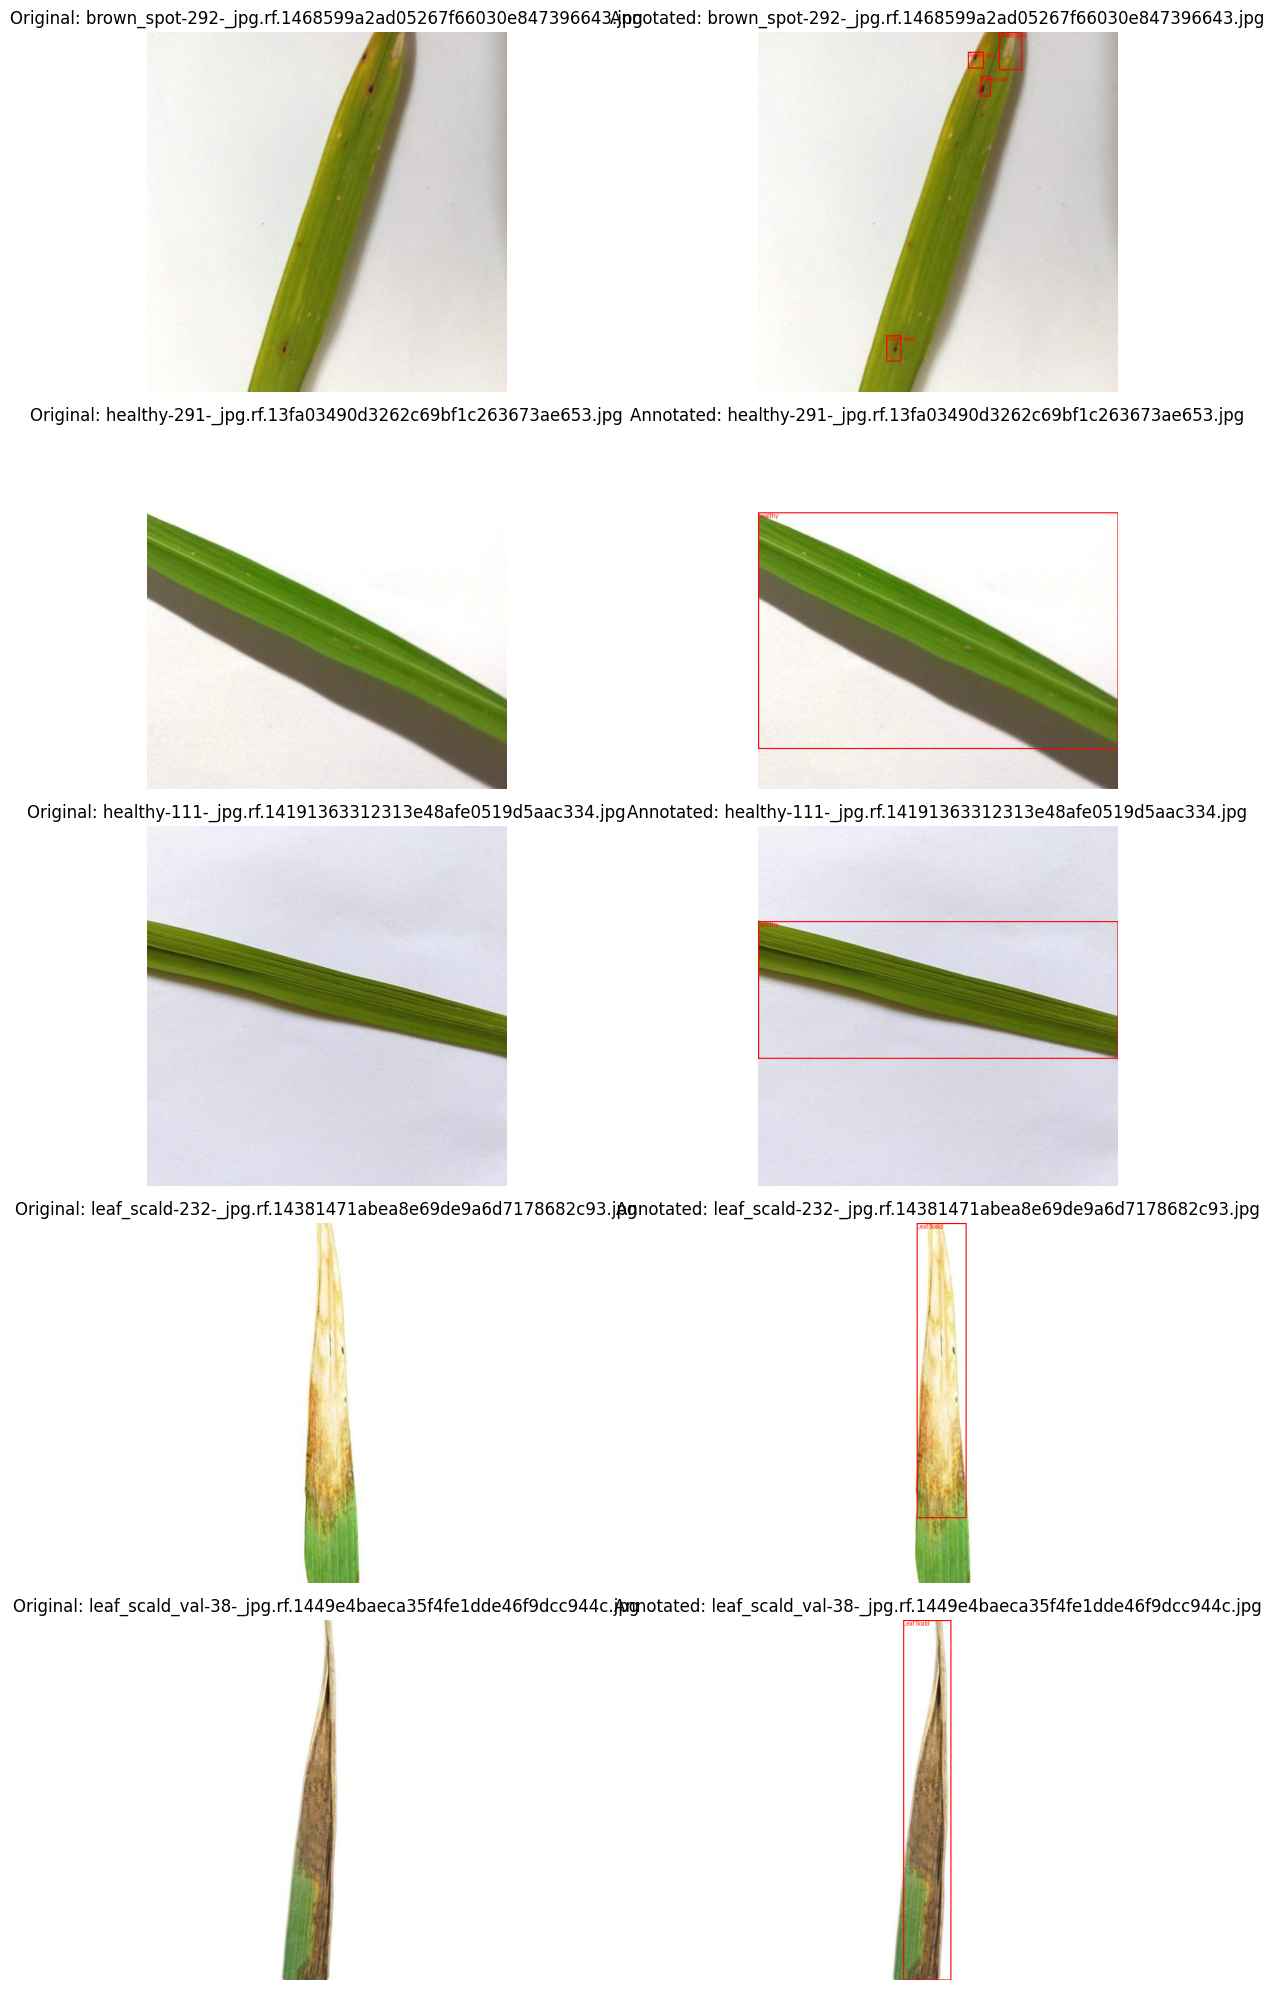

In [ ]:
# Function to display images and annotations for a specific image
def display_image_with_annotations(folder_name, image_id):
    # Find the image info
    image_info = next(img for img in coco_data[folder_name]['images'] if img['id'] == image_id)
    file_name = image_info['file_name']
    image_path = os.path.join(base_dir, folder_name, file_name)

    # Open the image
    img = Image.open(image_path)

    # Create a drawing context to draw bounding boxes
    draw = ImageDraw.Draw(img)

    # Get all annotations for the image
    image_annotations = [ann for ann in coco_data[folder_name]['annotations'] if ann['image_id'] == image_id]

    # Draw the bounding boxes and label them with class names
    for ann in image_annotations:
        category_id = ann['category_id']
        bbox = ann['bbox']
        disease_name = all_categories[category_id]

        # Draw bounding box (in COCO format, bbox = [x, y, width, height])
        x, y, width, height = bbox
        draw.rectangle([x, y, x + width, y + height], outline="red", width=2)

        # Draw label
        draw.text((x, y), disease_name, fill="red")

    return img

# Display 5 sample images with annotations from the train dataset
fig, axs = plt.subplots(5, 2, figsize=(15, 20))

for i, ax in enumerate(axs):
    # Display original image on the left
    image_info = coco_data['train']['images'][i]
    original_image_path = os.path.join(base_dir, 'train', image_info['file_name'])
    original_image = Image.open(original_image_path)
    ax[0].imshow(original_image)
    ax[0].set_title(f"Original: {image_info['file_name']}")
    ax[0].axis('off')

    # Display image with annotations on the right
    annotated_image = display_image_with_annotations('train', image_info['id'])
    ax[1].imshow(annotated_image)
    ax[1].set_title(f"Annotated: {image_info['file_name']}")
    ax[1].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Transformation
transform = T.Compose([
    T.Resize((640, 640)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load datasets using COCO format with MobileNet v3 Large FPN
train_dataset = torchvision.datasets.CocoDetection(root=os.path.join(base_dir, 'train'),
                                                  annFile=os.path.join(base_dir, 'train', '_annotations.coco.json'),
                                                  transform=transform)

valid_dataset = torchvision.datasets.CocoDetection(root=os.path.join(base_dir, 'valid'),
                                                 annFile=os.path.join(base_dir, 'valid', '_annotations.coco.json'),
                                                 transform=transform)
# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
valid_loader = DataLoader(valid_dataset, batch_size=4, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [ ]:
# Load pre-trained Faster R-CNN with MobileNet v3 Large FPN
model = fasterrcnn_mobilenet_v3_large_fpn(weights='FasterRCNN_MobileNet_V3_Large_FPN_Weights.DEFAULT')

# Modify the number of classes (7 classes including background)
num_classes = 7
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
# Move model to GPU if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): FrozenBatchNorm2d(16, eps=1e-05)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
            (2): ReLU(inplace=True)
          )
          (1): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
          )
        )
      )
      (2): InvertedResidual(
        (block):

In [ ]:
import torch
import torch.optim as optim
from tqdm import tqdm


# Set the number of epochs
num_epochs = 5

#  Optimizer and Scheduler
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.0005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)


def prepare_targets(targets):
    formatted_targets = []
    for t in targets:
        if len(t) == 0:
            print("No annotations for this image, skipping...")
            continue

        # Extract bounding boxes and check for validity
        boxes = torch.tensor([ann['bbox'] for ann in t if 'bbox' in ann], dtype=torch.float32)
        if boxes.size(0) == 0:
            print("No valid bounding boxes found for this image, skipping...")
            continue

        # Convert [x, y, width, height] -> [x_min, y_min, x_max, y_max]
        boxes[:, 2:] += boxes[:, :2]

        # Filter out invalid boxes (e.g., negative or zero-size)
        valid_boxes = []
        valid_labels = []
        for i, box in enumerate(boxes):
            x_min, y_min, x_max, y_max = box
            if (x_max > x_min) and (y_max > y_min):
                valid_boxes.append(box)
                valid_labels.append(t[i]['category_id'])
            else:
                print(f"Invalid bounding box removed: {box.tolist()}")

        if valid_boxes:
            formatted_target = {
                'boxes': torch.stack(valid_boxes),
                'labels': torch.tensor(valid_labels, dtype=torch.int64)
            }
            formatted_targets.append(formatted_target)
        else:
            print("No valid bounding boxes for this image, skipping...")

    return formatted_targets

# Debugging during DataLoader creation
def print_sample_annotations(dataset):
    for idx in range(5):  # Print the first 5 images for debugging
        img, annotations = dataset[idx]
        print(f"Image {idx} - Number of annotations: {len(annotations)}")
        for ann in annotations:
            print(f"  Annotation: {ann}")

print("Sample annotations from training dataset:")
print_sample_annotations(train_dataset)

Sample annotations from training dataset:
Image 0 - Number of annotations: 4
  Annotation: {'id': 0, 'image_id': 0, 'category_id': 1, 'bbox': [396, 78, 17, 36.5], 'area': 620.5, 'segmentation': [], 'iscrowd': 0}
  Annotation: {'id': 1, 'image_id': 0, 'category_id': 1, 'bbox': [373, 35, 28.5, 29.5], 'area': 840.75, 'segmentation': [], 'iscrowd': 0}
  Annotation: {'id': 2, 'image_id': 0, 'category_id': 1, 'bbox': [428, 0, 41, 67], 'area': 2747, 'segmentation': [], 'iscrowd': 0}
  Annotation: {'id': 3, 'image_id': 0, 'category_id': 1, 'bbox': [228, 539, 26.5, 46], 'area': 1219, 'segmentation': [], 'iscrowd': 0}
Image 1 - Number of annotations: 1
  Annotation: {'id': 4, 'image_id': 1, 'category_id': 6, 'bbox': [0, 148, 640, 420.4], 'area': 269056, 'segmentation': [[0, 243, 188, 341, 321, 405, 388, 438, 640, 568.4, 639.6, 482.8, 632.4, 476.8, 551.6, 428.4, 439.2, 363.2, 286, 282, 168.8, 225.2, 96.8, 193.6, 35.6, 170, 21, 159, 0, 148, 0, 243]], 'iscrowd': 0}
Image 2 - Number of annotations: 

In [ ]:
def train_one_epoch(model, optimizer, train_loader, device, epoch):
    model.train()
    running_loss = 0.0
    progress_bar = tqdm(train_loader, desc=f"Training Epoch {epoch+1}")
    for images, targets in progress_bar:
        images = [image.to(device) for image in images]
        targets = prepare_targets(targets)
        if not targets:
            continue
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        if len(images)!= len(targets):
            continue
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        running_loss += losses.item()
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        progress_bar.set_postfix(loss=running_loss / len(progress_bar))
    return running_loss / len(train_loader)

def evaluate(model, valid_loader, device):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for images, targets in tqdm(valid_loader, desc="Validating"):
            images = [image.to(device) for image in images]
            targets = prepare_targets(targets)
            if not targets:
                continue
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            if len(images)!= len(targets):
                continue
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            running_loss += losses.item()
    return running_loss / len(valid_loader)

def train_model(model, train_loader, num_epochs, optimizer, scheduler, device):
    for epoch in range(num_epochs):
        train_loss = train_one_epoch(model, optimizer, train_loader, device, epoch)
        print(f"Epoch {epoch+1}, Loss: {train_loss}")
        scheduler.step()

# Train the model
num_epochs = 10
train_model(model, train_loader, num_epochs, optimizer, lr_scheduler, device)

Training Epoch 1:  89%|████████▉ | 656/738 [01:46<00:10,  8.02it/s, loss=0.375]

No annotations for this image, skipping...


Training Epoch 1: 100%|██████████| 738/738 [01:59<00:00,  6.18it/s, loss=0.42]


Epoch 1, Loss: 0.41959679690076085


Training Epoch 2:  58%|█████▊    | 425/738 [01:05<00:36,  8.52it/s, loss=0.247]

No annotations for this image, skipping...


Training Epoch 2: 100%|██████████| 738/738 [01:52<00:00,  6.59it/s, loss=0.423]


Epoch 2, Loss: 0.4230328184883123


Training Epoch 3:   1%|          | 8/738 [00:01<01:23,  8.69it/s, loss=0.00379]

No annotations for this image, skipping...


Training Epoch 3: 100%|██████████| 738/738 [01:49<00:00,  6.74it/s, loss=0.41]


Epoch 3, Loss: 0.41020652435740157


Training Epoch 4:  76%|███████▌  | 562/738 [01:22<00:21,  8.28it/s, loss=0.307]

No annotations for this image, skipping...


Training Epoch 4: 100%|██████████| 738/738 [01:48<00:00,  6.82it/s, loss=0.401]


Epoch 4, Loss: 0.4006211566044709


Training Epoch 5:  12%|█▏        | 87/738 [00:12<01:17,  8.35it/s, loss=0.0465]

No annotations for this image, skipping...


Training Epoch 5: 100%|██████████| 738/738 [01:48<00:00,  6.83it/s, loss=0.398]


Epoch 5, Loss: 0.39763867556241145


Training Epoch 6:  51%|█████▏    | 380/738 [00:55<00:42,  8.33it/s, loss=0.201]

No annotations for this image, skipping...


Training Epoch 6: 100%|██████████| 738/738 [01:48<00:00,  6.81it/s, loss=0.394]


Epoch 6, Loss: 0.39353879664325453


Training Epoch 7:  82%|████████▏ | 604/738 [01:28<00:16,  8.22it/s, loss=0.323]

No annotations for this image, skipping...


Training Epoch 7: 100%|██████████| 738/738 [01:47<00:00,  6.85it/s, loss=0.39]


Epoch 7, Loss: 0.39037200527866356


Training Epoch 8:  80%|████████  | 593/738 [01:26<00:17,  8.07it/s, loss=0.313]

No annotations for this image, skipping...


Training Epoch 8: 100%|██████████| 738/738 [01:47<00:00,  6.85it/s, loss=0.391]


Epoch 8, Loss: 0.3912551487445185


Training Epoch 9:  11%|█         | 82/738 [00:11<01:21,  8.02it/s, loss=0.0437]

No annotations for this image, skipping...


Training Epoch 9: 100%|██████████| 738/738 [01:47<00:00,  6.85it/s, loss=0.39]


Epoch 9, Loss: 0.3902321449382518


Training Epoch 10:  99%|█████████▉| 729/738 [01:46<00:01,  8.22it/s, loss=0.382]

No annotations for this image, skipping...


Training Epoch 10: 100%|██████████| 738/738 [01:47<00:00,  6.85it/s, loss=0.387]

Epoch 10, Loss: 0.3870258678588764


In [ ]:
# Load test dataset using COCO format
from torchvision.datasets import CocoDetection

test_dataset = CocoDetection(root=os.path.join(base_dir, 'test'),
                             annFile=os.path.join(base_dir, 'test', '_annotations.coco.json'),
                             transform=transform)

# Create DataLoader for the test set
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))


loading annotations into memory...
Done (t=0.21s)
creating index...
index created!


In [ ]:
def evaluate_on_test(model, test_loader, device):
    model.eval()  # Set model to evaluation mode
    all_boxes = []
    all_labels = []
    all_scores = []

    with torch.no_grad():  # Disable gradient calculations for evaluation
        for images, targets in tqdm(test_loader, desc="Evaluating"):
            images = [image.to(device) for image in images]

            # Prepare targets (fixing the structure and validating bounding boxes)
            targets = prepare_targets(targets)

            # Get predictions
            predictions = model(images)

            # Collect boxes, labels, and scores for evaluation
            for i, prediction in enumerate(predictions):
                if len(prediction['boxes']) > 0:
                    all_boxes.append(prediction['boxes'].cpu())
                    all_labels.append(prediction['labels'].cpu())
                    all_scores.append(prediction['scores'].cpu())

    return all_boxes, all_labels, all_scores

In [ ]:
import numpy as np
from sklearn.metrics import average_precision_score

def compute_map(all_boxes, all_labels, all_scores, num_classes):
    y_true = np.zeros((0, num_classes))  # Initialize empty one-hot encoded array
    y_scores = np.zeros((0, num_classes))  # Initialize empty 2D scores array

    for cls in range(1, num_classes):  # start from 1 if class 0 is background
        cls_boxes = []
        cls_scores = []
        cls_labels = []

        for boxes, labels, scores in zip(all_boxes, all_labels, all_scores):
            # Ensure labels is a NumPy array
            labels = labels.numpy() if isinstance(labels, torch.Tensor) else labels

            # Create a mask for the current class
            cls_mask = (labels == cls)
            if np.any(cls_mask):  # Ensure there are samples for this class
                cls_boxes.append(boxes[cls_mask])
                cls_scores.append(scores[cls_mask])
                cls_labels.append(labels[cls_mask])

        if cls_boxes:
            cls_boxes = torch.cat(cls_boxes)
            cls_scores = torch.cat(cls_scores)

            # Convert cls_labels to tensors before concatenation
            cls_labels = torch.cat([torch.from_numpy(l) for l in cls_labels])

            # Prepare true labels in one-hot encoding
            cls_true_labels = np.zeros((len(cls_labels), num_classes))
            cls_true_labels[:, cls] = 1  # Set the corresponding class index to 1

            # Append true labels and scores
            y_true = np.vstack((y_true, cls_true_labels))

            # Convert cls_scores to 2D array where each class has its own column
            cls_score_2d = np.zeros((len(cls_scores), num_classes))
            cls_score_2d[:, cls] = cls_scores.numpy()  # Put scores in the corresponding class column
            y_scores = np.vstack((y_scores, cls_score_2d))

    # Calculate average precision for each class and then average them
    average_precisions = []
    for i in range(num_classes - 1):  # excluding background
        average_precisions.append(average_precision_score(y_true[:, i], y_scores[:, i]))

    mean_ap = np.mean(average_precisions)  # Mean Average Precision (mAP)
    return mean_ap

In [ ]:
# Evaluate on the test dataset
all_boxes, all_labels, all_scores = evaluate_on_test(model, test_loader, device)

# Compute mAP
map_score = compute_map(all_boxes, all_labels, all_scores, num_classes)
print(f"Mean Average Precision (mAP) on the test dataset: {map_score:.4f}")

Evaluating: 100%|██████████| 62/62 [00:08<00:00,  7.42it/s]

Mean Average Precision (mAP) on the test dataset: 0.8214



No positive class found in y_true, recall is set to one for all thresholds.


In [ ]:
import os
import torch
import numpy as np
from torchvision.datasets import CocoDetection
from torch.utils.data import DataLoader
import torchvision.transforms as T

# Unified function to preprocess the image (same as training preprocessing)
def preprocess_image(image):
    if isinstance(image, torch.Tensor):
        return image  # If it's already a tensor, return it
    transform = T.Compose([
        T.Resize((640, 640)),  # Resize to 640x640 (same as training)
        T.ToTensor(),  # Convert image to tensor
        T.Normalize(mean=[0.485, 0.456, 0.406],  # Normalize using ImageNet mean
                    std=[0.229, 0.224, 0.225])  # Normalize using ImageNet std
    ])
    return transform(image)

# Function to compute Precision and Recall based on predicted class labels
def evaluate_precision_recall_on_dataset(model, test_loader, device, conf_threshold=0.7):
    # Initialize counts
    tp = 0  # True Positives
    fp = 0  # False Positives
    fn = 0  # False Negatives

    model.eval()  # Set model to evaluation mode

    with torch.no_grad():
        for images, annotations in test_loader:
            # Preprocess images and send to device
            images = [preprocess_image(image).to(device) for image in images]

            # Get predictions from the model
            predictions = model(images)

            # Loop over each image in the batch
            for i, prediction in enumerate(predictions):
                predicted_labels = prediction['labels'].cpu().numpy()  # Predicted class labels
                predicted_scores = prediction['scores'].cpu().numpy()  # Prediction confidence scores

                # Apply confidence threshold
                predicted_labels = predicted_labels[predicted_scores >= conf_threshold]

                gt_labels = np.array([ann['category_id'] for ann in annotations[i]])  # Ground truth labels

                # Compute TP, FP, FN based on class labels
                for pred_label in predicted_labels:
                    if pred_label in gt_labels:
                        tp += 1  # Correct class prediction
                    else:
                        fp += 1  # Incorrect class prediction

                # FN: Ground truth labels not detected by the model
                fn += len(gt_labels) - sum([1 for gt_label in gt_labels if gt_label in predicted_labels])

    # Calculate precision and recall
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0

    return precision, recall

# Load test dataset using COCO format
base_dir = '/content/Rice-leaf-disease-1'
test_dataset = CocoDetection(root=os.path.join(base_dir, 'test'),
                             annFile=os.path.join(base_dir, 'test', '_annotations.coco.json'))

# Create DataLoader for test dataset
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))
# Set device (CPU or CUDA)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Adjust confidence threshold as needed
confidence_threshold = 0.5  # You can adjust this value

# Evaluate the model on the test dataset for Precision and Recall
precision, recall = evaluate_precision_recall_on_dataset(model, test_loader, device, conf_threshold=confidence_threshold)

# Convert to percentages
precision_percentage = precision * 100
recall_percentage = recall * 100

print(f"Precision (P%): {precision_percentage:.2f}%")
print(f"Recall (R%): {recall_percentage:.2f}%")

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Precision (P%): 92.80%
Recall (R%): 53.61%


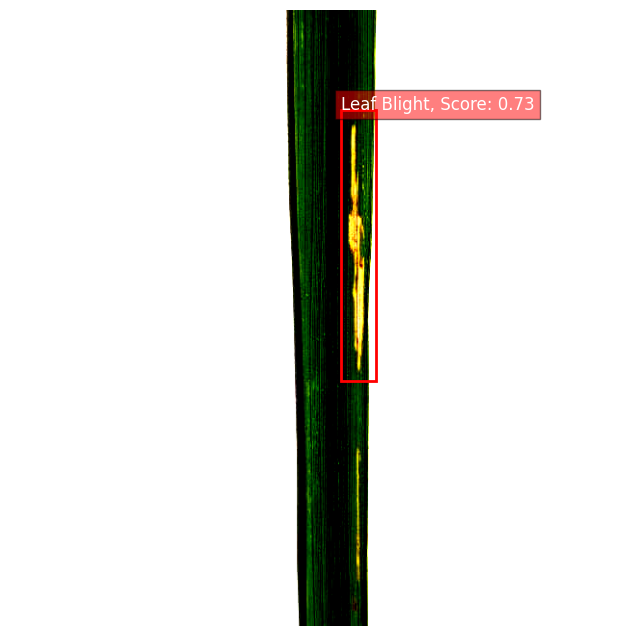

In [ ]:
import matplotlib.pyplot as plt
import torch
from PIL import Image
import torchvision.transforms as T
class_names = {0: 'rice', 1: 'Brown spot', 2: 'Leaf Blight', 3: 'Leaf Scald', 4: 'Leaf blast', 5: 'Narrow brown spot', 6: 'healthy'}  # Update with your actual class names


# Function to preprocess the image
def preprocess_image(image_path, device):
    # Define the transformation for the input image (Resize, Normalize, etc.)
    transform = T.Compose([
        T.Resize((640, 640)),  # Resize to 640x640
        T.ToTensor(),  # Convert image to tensor
        T.Normalize(mean=[0.485, 0.456, 0.406],  # Normalize using ImageNet mean
                    std=[0.229, 0.224, 0.225])  # Normalize using ImageNet std
    ])

    # Load the image using PIL
    image = Image.open(image_path).convert("RGB")

    # Apply transformations
    image_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension and move to device
    return image_tensor, image


# Function to visualize the prediction on a user-provided image
def visualize_user_image(image, predictions, class_names):
    # Convert tensor image to numpy array for visualization
    image_np = image.permute(1, 2, 0).cpu().numpy()  # Convert to HWC format

    # Draw predicted boxes
    boxes = predictions[0]['boxes'].cpu().detach().numpy()  # Use detach to avoid tracking gradients
    labels = predictions[0]['labels'].cpu().detach().numpy()
    scores = predictions[0]['scores'].cpu().detach().numpy()

    # Display the image
    plt.figure(figsize=(12, 8))
    plt.imshow(image_np)

    for box, label, score in zip(boxes, labels, scores):
        if score > 0.5:  # Show boxes with a score above a certain threshold
            x_min, y_min, x_max, y_max = box  # Adjust based on your box format
            rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                 fill=False, color='red', linewidth=2)
            plt.gca().add_patch(rect)
            # Replace label with class name
            class_name = class_names[int(label)]
            plt.text(x_min, y_min, f'{class_name}, Score: {score:.2f}',
                     color='white', fontsize=12, bbox=dict(facecolor='red', alpha=0.5))

    plt.axis('off')
    plt.show()

# Function to perform prediction on a user-provided image
def predict_on_user_image(model, image_path, device, class_names):
    # Preprocess the image
    image_tensor, original_image = preprocess_image(image_path, device)

    # Set the model to evaluation mode
    model.eval()

    # Run the model on the input image
    with torch.no_grad():
        # Remove the extra brackets to pass the 4D tensor directly
        predictions = model(image_tensor)

    # Visualize the results
    visualize_user_image(image_tensor[0], predictions, class_names)

# Example usage:
# Let's say the user provides an image file named 'test_image.jpg'
image_path = '/content/Rice-leaf-disease-1/test/bacterial_leaf_blight-18-_JPG_jpg.rf.e5b28708b295d713f0606ec9b1312ff0.jpg'  # Replace with the actual image path
predict_on_user_image(model, image_path, device, class_names)


In [ ]:
torch.save(model, 'faster_rcnn_MobileNet_v3_Large.pt')

In [ ]:
model = torch.load('faster_rcnn_MobileNet_v3_Large.pt')
model.eval()


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): FrozenBatchNorm2d(16, eps=1e-05)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
            (2): ReLU(inplace=True)
          )
          (1): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
          )
        )
      )
      (2): InvertedResidual(
        (block):

# **Faster RCNN with Densenet121**

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="3yeDfLL9a4WwAyvMETBG")
project = rf.workspace("harsha-etczl").project("rice-leaf-disease-pnczf")
version = project.version(1)
dataset = version.download("coco")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.9/80.9 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.4 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Rice-leaf-disease-1 in coco:: 100%|██████████| 3686/3686 [00:01<00:00, 2026.60it/s]


In [ ]:
import os
import json
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import collections
import torch
import torchvision
from torchvision.models.detection import FasterRCNN, fasterrcnn_mobilenet_v3_large_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision import transforms as T
from torch.utils.data import DataLoader
from tqdm import tqdm

# Define the path to the base directory where train, valid, test folders are stored
base_dir = '/content/Rice-leaf-disease-1'

# Folders to check
folders = ['train', 'valid', 'test']

# Initialize categories to keep track of categories across all datasets
all_categories = {}
coco_data = {}

# Function to load and check annotation files
def check_annotations(folder_name):
    annotation_file = os.path.join(base_dir, folder_name, '_annotations.coco.json')

    if os.path.exists(annotation_file):
        print(f"\nChecking annotations for the {folder_name} folder:")
        with open(annotation_file, 'r') as f:
            coco_data[folder_name] = json.load(f)

        # Print an overview of the annotations
        print("Categories: ", coco_data[folder_name].get('categories', 'No categories found'))
        print("Number of Images: ", len(coco_data[folder_name].get('images', [])))
        print("Number of Annotations: ", len(coco_data[folder_name].get('annotations', [])))

        # Add categories to the global dictionary
        for category in coco_data[folder_name]['categories']:
            all_categories[category['id']] = category['name']

        # Check if 'image_id', 'category_id', and 'bbox' fields are present in annotations
        if coco_data[folder_name].get('annotations'):
            for annotation in coco_data[folder_name]['annotations'][:5]:  # Print first 5 annotations as a sample
                print("Annotation example: ", annotation)
                assert 'image_id' in annotation, "Missing 'image_id' in annotation"
                assert 'category_id' in annotation, "Missing 'category_id' in annotation"
                assert 'bbox' in annotation, "Missing 'bbox' in annotation"
        else:
            print(f"No annotations found in {folder_name}!")
    else:
        print(f"Annotation file not found in {folder_name} folder")

# Check annotations for all folders: train, valid, test
for folder in folders:
    check_annotations(folder)


Checking annotations for the train folder:
Categories:  [{'id': 0, 'name': 'rice', 'supercategory': 'none'}, {'id': 1, 'name': 'Brown spot', 'supercategory': 'rice'}, {'id': 2, 'name': 'Leaf Blight', 'supercategory': 'rice'}, {'id': 3, 'name': 'Leaf Scald', 'supercategory': 'rice'}, {'id': 4, 'name': 'Leaf blast', 'supercategory': 'rice'}, {'id': 5, 'name': 'Narrow brown spot', 'supercategory': 'rice'}, {'id': 6, 'name': 'healthy', 'supercategory': 'rice'}]
Number of Images:  2949
Number of Annotations:  7287
Annotation example:  {'id': 0, 'image_id': 0, 'category_id': 1, 'bbox': [396, 78, 17, 36.5], 'area': 620.5, 'segmentation': [], 'iscrowd': 0}
Annotation example:  {'id': 1, 'image_id': 0, 'category_id': 1, 'bbox': [373, 35, 28.5, 29.5], 'area': 840.75, 'segmentation': [], 'iscrowd': 0}
Annotation example:  {'id': 2, 'image_id': 0, 'category_id': 1, 'bbox': [428, 0, 41, 67], 'area': 2747, 'segmentation': [], 'iscrowd': 0}
Annotation example:  {'id': 3, 'image_id': 0, 'category_id'

In [ ]:
# Extract category names from the aggregated categories
print("\nAll Disease categories across datasets: ", all_categories)


All Disease categories across datasets:  {0: 'rice', 1: 'Brown spot', 2: 'Leaf Blight', 3: 'Leaf Scald', 4: 'Leaf blast', 5: 'Narrow brown spot', 6: 'healthy'}


In [ ]:
# Transformation
transform = T.Compose([
    T.Resize((640, 640)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load datasets using COCO format with MobileNet v3 Large FPN
train_dataset = torchvision.datasets.CocoDetection(root=os.path.join(base_dir, 'train'),
                                                  annFile=os.path.join(base_dir, 'train', '_annotations.coco.json'),
                                                  transform=transform)

valid_dataset = torchvision.datasets.CocoDetection(root=os.path.join(base_dir, 'valid'),
                                                 annFile=os.path.join(base_dir, 'valid', '_annotations.coco.json'),
                                                 transform=transform)
# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
valid_loader = DataLoader(valid_dataset, batch_size=4, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
loading annotations into memory...
Done (t=0.16s)
creating index...
index created!


In [ ]:
import torch
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models import densenet121
from torch.utils.data import DataLoader
from torchvision.transforms import functional as F
import torchvision.transforms as T
from torchvision.datasets.coco import CocoDetection

# Load the pretrained DenseNet model
densenet = densenet121(weights="DenseNet121_Weights.DEFAULT")

# Use the features (up to the last convolutional layer) as the backbone
backbone = torch.nn.Sequential(*list(densenet.features.children()))

# Freeze the backbone (optional: depends on whether you want to fine-tune it)
for param in backbone.parameters():
    param.requires_grad = False

# Add a layer to adapt the output channels of DenseNet's feature extractor
# Faster R-CNN expects an output feature size of 7x7; DenseNet has 1024 channels
backbone.out_channels = 1024

# Define the Anchor Generator
# The sizes and aspect ratios here are examples; adjust as needed for your dataset
anchor_generator = AnchorGenerator(
    sizes=((32, 64, 128, 256, 512),),
    aspect_ratios=((0.5, 1.0, 2.0),)
)

# Define the ROI Pooler
roi_pooler = torchvision.ops.MultiScaleRoIAlign(
    featmap_names=['0'],  # Specify the feature map names
    output_size=7,        # Pooling to 7x7
    sampling_ratio=2
)

# Define the Faster R-CNN model
model = FasterRCNN(
    backbone,
    num_classes=7,  # Adjust for your dataset (6 classes + background)
    rpn_anchor_generator=anchor_generator,
    box_roi_pool=roi_pooler
)

# Move the model to the appropriate device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Display the model structure for debugging
print(model)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 144MB/s]


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False

In [ ]:
import torch
import torch.optim as optim
from tqdm import tqdm


# Set the number of epochs
num_epochs = 10

#  Optimizer and Scheduler
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.0005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)


def prepare_targets(targets):
    formatted_targets = []
    for t in targets:
        if len(t) == 0:
            print("No annotations for this image, skipping...")
            continue

        # Extract bounding boxes and check for validity
        boxes = torch.tensor([ann['bbox'] for ann in t if 'bbox' in ann], dtype=torch.float32)
        if boxes.size(0) == 0:
            print("No valid bounding boxes found for this image, skipping...")
            continue

        # Convert [x, y, width, height] -> [x_min, y_min, x_max, y_max]
        boxes[:, 2:] += boxes[:, :2]

        # Filter out invalid boxes (e.g., negative or zero-size)
        valid_boxes = []
        valid_labels = []
        for i, box in enumerate(boxes):
            x_min, y_min, x_max, y_max = box
            if (x_max > x_min) and (y_max > y_min):
                valid_boxes.append(box)
                valid_labels.append(t[i]['category_id'])
            else:
                print(f"Invalid bounding box removed: {box.tolist()}")

        if valid_boxes:
            formatted_target = {
                'boxes': torch.stack(valid_boxes),
                'labels': torch.tensor(valid_labels, dtype=torch.int64)
            }
            formatted_targets.append(formatted_target)
        else:
            print("No valid bounding boxes for this image, skipping...")

    return formatted_targets

# Debugging during DataLoader creation
def print_sample_annotations(dataset):
    for idx in range(5):  # Print the first 5 images for debugging
        img, annotations = dataset[idx]
        print(f"Image {idx} - Number of annotations: {len(annotations)}")
        for ann in annotations:
            print(f"  Annotation: {ann}")

print("Sample annotations from training dataset:")
print_sample_annotations(train_dataset)

Sample annotations from training dataset:
Image 0 - Number of annotations: 4
  Annotation: {'id': 0, 'image_id': 0, 'category_id': 1, 'bbox': [396, 78, 17, 36.5], 'area': 620.5, 'segmentation': [], 'iscrowd': 0}
  Annotation: {'id': 1, 'image_id': 0, 'category_id': 1, 'bbox': [373, 35, 28.5, 29.5], 'area': 840.75, 'segmentation': [], 'iscrowd': 0}
  Annotation: {'id': 2, 'image_id': 0, 'category_id': 1, 'bbox': [428, 0, 41, 67], 'area': 2747, 'segmentation': [], 'iscrowd': 0}
  Annotation: {'id': 3, 'image_id': 0, 'category_id': 1, 'bbox': [228, 539, 26.5, 46], 'area': 1219, 'segmentation': [], 'iscrowd': 0}
Image 1 - Number of annotations: 1
  Annotation: {'id': 4, 'image_id': 1, 'category_id': 6, 'bbox': [0, 148, 640, 420.4], 'area': 269056, 'segmentation': [[0, 243, 188, 341, 321, 405, 388, 438, 640, 568.4, 639.6, 482.8, 632.4, 476.8, 551.6, 428.4, 439.2, 363.2, 286, 282, 168.8, 225.2, 96.8, 193.6, 35.6, 170, 21, 159, 0, 148, 0, 243]], 'iscrowd': 0}
Image 2 - Number of annotations: 

In [ ]:
def train_one_epoch(model, optimizer, train_loader, device, epoch):
    model.train()
    running_loss = 0.0
    progress_bar = tqdm(train_loader, desc=f"Training Epoch {epoch+1}")
    for images, targets in progress_bar:
        images = [image.to(device) for image in images]
        targets = prepare_targets(targets)
        if not targets:
            continue
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        if len(images)!= len(targets):
            continue
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        running_loss += losses.item()
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        progress_bar.set_postfix(loss=running_loss / len(progress_bar))
    return running_loss / len(train_loader)

def evaluate(model, valid_loader, device):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for images, targets in tqdm(valid_loader, desc="Validating"):
            images = [image.to(device) for image in images]
            targets = prepare_targets(targets)
            if not targets:
                continue
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            if len(images)!= len(targets):
                continue
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            running_loss += losses.item()
    return running_loss / len(valid_loader)

def train_model(model, train_loader, num_epochs, optimizer, scheduler, device):
    for epoch in range(num_epochs):
        train_loss = train_one_epoch(model, optimizer, train_loader, device, epoch)
        print(f"Epoch {epoch+1}, Loss: {train_loss}")
        scheduler.step()

# Train the model
num_epochs = 10
train_model(model, train_loader, num_epochs, optimizer, lr_scheduler, device)

Training Epoch 1:   0%|          | 3/738 [00:03<10:17,  1.19it/s, loss=0.0111]

No annotations for this image, skipping...


Training Epoch 1: 100%|██████████| 738/738 [04:12<00:00,  2.92it/s, loss=0.437]


Epoch 1, Loss: 0.43725146696496464


Training Epoch 2: 100%|█████████▉| 735/738 [04:11<00:01,  2.90it/s, loss=0.313]

No annotations for this image, skipping...


Training Epoch 2: 100%|██████████| 738/738 [04:12<00:00,  2.92it/s, loss=0.314]


Epoch 2, Loss: 0.3137421916695791


Training Epoch 3:  57%|█████▋    | 418/738 [02:23<01:49,  2.92it/s, loss=0.169]

No annotations for this image, skipping...


Training Epoch 3: 100%|██████████| 738/738 [04:12<00:00,  2.92it/s, loss=0.287]


Epoch 3, Loss: 0.28743334605199533


Training Epoch 4:  27%|██▋       | 197/738 [01:07<03:05,  2.92it/s, loss=0.0761]

No annotations for this image, skipping...


Training Epoch 4: 100%|██████████| 738/738 [04:12<00:00,  2.93it/s, loss=0.278]


Epoch 4, Loss: 0.2776076806593071


Training Epoch 5:  67%|██████▋   | 491/738 [02:47<01:24,  2.93it/s, loss=0.185]

No annotations for this image, skipping...


Training Epoch 5: 100%|██████████| 738/738 [04:12<00:00,  2.93it/s, loss=0.275]


Epoch 5, Loss: 0.27518163310479987


Training Epoch 6:  67%|██████▋   | 494/738 [02:49<01:23,  2.92it/s, loss=0.184]

No annotations for this image, skipping...


Training Epoch 6: 100%|██████████| 738/738 [04:12<00:00,  2.92it/s, loss=0.275]


Epoch 6, Loss: 0.27474287402662156


Training Epoch 7:  93%|█████████▎| 688/738 [03:55<00:17,  2.93it/s, loss=0.256]

No annotations for this image, skipping...


Training Epoch 7: 100%|██████████| 738/738 [04:12<00:00,  2.92it/s, loss=0.274]


Epoch 7, Loss: 0.27396177563079327


Training Epoch 8:  48%|████▊     | 352/738 [02:00<02:12,  2.92it/s, loss=0.13]

No annotations for this image, skipping...


Training Epoch 8: 100%|██████████| 738/738 [04:12<00:00,  2.93it/s, loss=0.273]


Epoch 8, Loss: 0.2731988028216814


Training Epoch 9:  57%|█████▋    | 419/738 [02:23<01:49,  2.91it/s, loss=0.154]

No annotations for this image, skipping...


Training Epoch 9: 100%|██████████| 738/738 [04:12<00:00,  2.92it/s, loss=0.272]


Epoch 9, Loss: 0.2717118224073555


Training Epoch 10:  94%|█████████▍| 695/738 [03:58<00:14,  2.92it/s, loss=0.257]

No annotations for this image, skipping...


Training Epoch 10: 100%|██████████| 738/738 [04:12<00:00,  2.92it/s, loss=0.273]

Epoch 10, Loss: 0.27281273517828325


In [ ]:
# Load test dataset using COCO format
from torchvision.datasets import CocoDetection

test_dataset = CocoDetection(root=os.path.join(base_dir, 'test'),
                             annFile=os.path.join(base_dir, 'test', '_annotations.coco.json'),
                             transform=transform)

# Create DataLoader for the test set
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [ ]:
def evaluate_on_test(model, test_loader, device):
    model.eval()  # Set model to evaluation mode
    all_boxes = []
    all_labels = []
    all_scores = []

    with torch.no_grad():  # Disable gradient calculations for evaluation
        for images, targets in tqdm(test_loader, desc="Evaluating"):
            images = [image.to(device) for image in images]

            # Prepare targets (fixing the structure and validating bounding boxes)
            targets = prepare_targets(targets)

            # Get predictions
            predictions = model(images)

            # Collect boxes, labels, and scores for evaluation
            for i, prediction in enumerate(predictions):
                if len(prediction['boxes']) > 0:
                    all_boxes.append(prediction['boxes'].cpu())
                    all_labels.append(prediction['labels'].cpu())
                    all_scores.append(prediction['scores'].cpu())

    return all_boxes, all_labels, all_scores

In [ ]:
import numpy as np
from sklearn.metrics import average_precision_score

def compute_map(all_boxes, all_labels, all_scores, num_classes):
    y_true = np.zeros((0, num_classes))  # Initialize empty one-hot encoded array
    y_scores = np.zeros((0, num_classes))  # Initialize empty 2D scores array

    for cls in range(1, num_classes):  # start from 1 if class 0 is background
        cls_boxes = []
        cls_scores = []
        cls_labels = []

        for boxes, labels, scores in zip(all_boxes, all_labels, all_scores):
            # Ensure labels is a NumPy array
            labels = labels.numpy() if isinstance(labels, torch.Tensor) else labels

            # Create a mask for the current class
            cls_mask = (labels == cls)
            if np.any(cls_mask):  # Ensure there are samples for this class
                cls_boxes.append(boxes[cls_mask])
                cls_scores.append(scores[cls_mask])
                cls_labels.append(labels[cls_mask])

        if cls_boxes:
            cls_boxes = torch.cat(cls_boxes)
            cls_scores = torch.cat(cls_scores)

            # Convert cls_labels to tensors before concatenation
            cls_labels = torch.cat([torch.from_numpy(l) for l in cls_labels])

            # Prepare true labels in one-hot encoding
            cls_true_labels = np.zeros((len(cls_labels), num_classes))
            cls_true_labels[:, cls] = 1  # Set the corresponding class index to 1

            # Append true labels and scores
            y_true = np.vstack((y_true, cls_true_labels))

            # Convert cls_scores to 2D array where each class has its own column
            cls_score_2d = np.zeros((len(cls_scores), num_classes))
            cls_score_2d[:, cls] = cls_scores.numpy()  # Put scores in the corresponding class column
            y_scores = np.vstack((y_scores, cls_score_2d))

    # Calculate average precision for each class and then average them
    average_precisions = []
    for i in range(num_classes - 1):  # excluding background
        average_precisions.append(average_precision_score(y_true[:, i], y_scores[:, i]))

    mean_ap = np.mean(average_precisions)  # Mean Average Precision (mAP)
    return mean_ap

In [ ]:
# Evaluate on the test dataset
all_boxes, all_labels, all_scores = evaluate_on_test(model, test_loader, device)

# Compute mAP
map_score = compute_map(all_boxes, all_labels, all_scores, num_classes)
print(f"Mean Average Precision (mAP) on the test dataset: {map_score:.4f}")

Evaluating: 100%|██████████| 62/62 [00:17<00:00,  3.63it/s]

Mean Average Precision (mAP) on the test dataset: 0.7840


In [ ]:
import os
import torch
import numpy as np
from torchvision.datasets import CocoDetection
from torch.utils.data import DataLoader
import torchvision.transforms as T

# Unified function to preprocess the image (same as training preprocessing)
def preprocess_image(image):
    if isinstance(image, torch.Tensor):
        return image  # If it's already a tensor, return it
    transform = T.Compose([
        T.Resize((640, 640)),  # Resize to 640x640 (same as training)
        T.ToTensor(),  # Convert image to tensor
        T.Normalize(mean=[0.485, 0.456, 0.406],  # Normalize using ImageNet mean
                    std=[0.229, 0.224, 0.225])  # Normalize using ImageNet std
    ])
    return transform(image)

# Function to compute Precision and Recall based on predicted class labels
def evaluate_precision_recall_on_dataset(model, test_loader, device, conf_threshold=0.7):
    # Initialize counts
    tp = 0  # True Positives
    fp = 0  # False Positives
    fn = 0  # False Negatives

    model.eval()  # Set model to evaluation mode

    with torch.no_grad():
        for images, annotations in test_loader:
            # Preprocess images and send to device
            images = [preprocess_image(image).to(device) for image in images]

            # Get predictions from the model
            predictions = model(images)

            # Loop over each image in the batch
            for i, prediction in enumerate(predictions):
                predicted_labels = prediction['labels'].cpu().numpy()  # Predicted class labels
                predicted_scores = prediction['scores'].cpu().numpy()  # Prediction confidence scores

                # Apply confidence threshold
                predicted_labels = predicted_labels[predicted_scores >= conf_threshold]

                gt_labels = np.array([ann['category_id'] for ann in annotations[i]])  # Ground truth labels

                # Compute TP, FP, FN based on class labels
                for pred_label in predicted_labels:
                    if pred_label in gt_labels:
                        tp += 1  # Correct class prediction
                    else:
                        fp += 1  # Incorrect class prediction

                # FN: Ground truth labels not detected by the model
                fn += len(gt_labels) - sum([1 for gt_label in gt_labels if gt_label in predicted_labels])

    # Calculate precision and recall
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0

    return precision, recall

# Load test dataset using COCO format
base_dir = '/content/Rice-leaf-disease-1'
test_dataset = CocoDetection(root=os.path.join(base_dir, 'test'),
                             annFile=os.path.join(base_dir, 'test', '_annotations.coco.json'))

# Create DataLoader for test dataset
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))
# Set device (CPU or CUDA)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Adjust confidence threshold as needed
confidence_threshold = 0.5  # You can adjust this value

# Evaluate the model on the test dataset for Precision and Recall
precision, recall = evaluate_precision_recall_on_dataset(model, test_loader, device, conf_threshold=confidence_threshold)

# Convert to percentages
precision_percentage = precision * 100
recall_percentage = recall * 100

print(f"Precision (P%): {precision_percentage:.2f}%")
print(f"Recall (R%): {recall_percentage:.2f}%")

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Precision (P%): 75.40%
Recall (R%): 64.60%


In [ ]:
torch.save(model, 'faster_rcnn_Dense121.pt')

In [ ]:
model = torch.load('faster_rcnn_Dense121.pt')
model.eval()


You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False

# **Faster RCNN with Resnet-50**

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="3yeDfLL9a4WwAyvMETBG")
project = rf.workspace("harsha-etczl").project("rice-leaf-disease-pnczf")
version = project.version(1)
dataset = version.download("coco")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.9/80.9 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.3 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Rice-leaf-disease-1 in coco:: 100%|██████████| 3686/3686 [00:00<00:00, 6221.09it/s]


In [ ]:
import os
import json
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import collections
import torch
import torchvision
from torchvision.models.detection import FasterRCNN, fasterrcnn_mobilenet_v3_large_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision import transforms as T
from torch.utils.data import DataLoader
from tqdm import tqdm

# Define the path to the base directory where train, valid, test folders are stored
base_dir = '/content/Rice-leaf-disease-1'

# Folders to check
folders = ['train', 'valid', 'test']

# Initialize categories to keep track of categories across all datasets
all_categories = {}
coco_data = {}

# Function to load and check annotation files
def check_annotations(folder_name):
    annotation_file = os.path.join(base_dir, folder_name, '_annotations.coco.json')

    if os.path.exists(annotation_file):
        print(f"\nChecking annotations for the {folder_name} folder:")
        with open(annotation_file, 'r') as f:
            coco_data[folder_name] = json.load(f)

        # Print an overview of the annotations
        print("Categories: ", coco_data[folder_name].get('categories', 'No categories found'))
        print("Number of Images: ", len(coco_data[folder_name].get('images', [])))
        print("Number of Annotations: ", len(coco_data[folder_name].get('annotations', [])))

        # Add categories to the global dictionary
        for category in coco_data[folder_name]['categories']:
            all_categories[category['id']] = category['name']

        # Check if 'image_id', 'category_id', and 'bbox' fields are present in annotations
        if coco_data[folder_name].get('annotations'):
            for annotation in coco_data[folder_name]['annotations'][:5]:  # Print first 5 annotations as a sample
                print("Annotation example: ", annotation)
                assert 'image_id' in annotation, "Missing 'image_id' in annotation"
                assert 'category_id' in annotation, "Missing 'category_id' in annotation"
                assert 'bbox' in annotation, "Missing 'bbox' in annotation"
        else:
            print(f"No annotations found in {folder_name}!")
    else:
        print(f"Annotation file not found in {folder_name} folder")

# Check annotations for all folders: train, valid, test
for folder in folders:
    check_annotations(folder)


Checking annotations for the train folder:
Categories:  [{'id': 0, 'name': 'rice', 'supercategory': 'none'}, {'id': 1, 'name': 'Brown spot', 'supercategory': 'rice'}, {'id': 2, 'name': 'Leaf Blight', 'supercategory': 'rice'}, {'id': 3, 'name': 'Leaf Scald', 'supercategory': 'rice'}, {'id': 4, 'name': 'Leaf blast', 'supercategory': 'rice'}, {'id': 5, 'name': 'Narrow brown spot', 'supercategory': 'rice'}, {'id': 6, 'name': 'healthy', 'supercategory': 'rice'}]
Number of Images:  2949
Number of Annotations:  7287
Annotation example:  {'id': 0, 'image_id': 0, 'category_id': 1, 'bbox': [396, 78, 17, 36.5], 'area': 620.5, 'segmentation': [], 'iscrowd': 0}
Annotation example:  {'id': 1, 'image_id': 0, 'category_id': 1, 'bbox': [373, 35, 28.5, 29.5], 'area': 840.75, 'segmentation': [], 'iscrowd': 0}
Annotation example:  {'id': 2, 'image_id': 0, 'category_id': 1, 'bbox': [428, 0, 41, 67], 'area': 2747, 'segmentation': [], 'iscrowd': 0}
Annotation example:  {'id': 3, 'image_id': 0, 'category_id'

In [ ]:
# Extract category names from the aggregated categories
print("\nAll Disease categories across datasets: ", all_categories)


All Disease categories across datasets:  {0: 'rice', 1: 'Brown spot', 2: 'Leaf Blight', 3: 'Leaf Scald', 4: 'Leaf blast', 5: 'Narrow brown spot', 6: 'healthy'}


In [ ]:
# Transformation
transform = T.Compose([
    T.Resize((640, 640)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load datasets using COCO format with MobileNet v3 Large FPN
train_dataset = torchvision.datasets.CocoDetection(root=os.path.join(base_dir, 'train'),
                                                  annFile=os.path.join(base_dir, 'train', '_annotations.coco.json'),
                                                  transform=transform)

valid_dataset = torchvision.datasets.CocoDetection(root=os.path.join(base_dir, 'valid'),
                                                 annFile=os.path.join(base_dir, 'valid', '_annotations.coco.json'),
                                                 transform=transform)
# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
valid_loader = DataLoader(valid_dataset, batch_size=4, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

loading annotations into memory...
Done (t=0.16s)
creating index...
index created!
loading annotations into memory...
Done (t=0.03s)
creating index...
index created!


In [ ]:
# Import the necessary libraries
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
import torch
import torch.optim as optim
from tqdm import tqdm
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN

# Modify the number of classes (7 classes including background)
num_classes = 7

# Load pretrained Faster R-CNN model
model = fasterrcnn_resnet50_fpn(weights='FasterRCNN_ResNet50_FPN_Weights.DEFAULT')

in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Move model to GPU if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 183MB/s]


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
import torch
import torch.optim as optim
from tqdm import tqdm


# Set the number of epochs
num_epochs = 5

#  Optimizer and Scheduler
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

def prepare_targets(targets):
    formatted_targets = []
    for t in targets:
        if len(t) == 0:
            print("No annotations for this image, skipping...")
            continue

        # Extract bounding boxes and check for validity
        boxes = torch.tensor([ann['bbox'] for ann in t if 'bbox' in ann], dtype=torch.float32)
        if boxes.size(0) == 0:
            print("No valid bounding boxes found for this image, skipping...")
            continue

        # Convert [x, y, width, height] -> [x_min, y_min, x_max, y_max]
        boxes[:, 2:] += boxes[:, :2]

        # Filter out invalid boxes (e.g., negative or zero-size)
        valid_boxes = []
        valid_labels = []
        for i, box in enumerate(boxes):
            x_min, y_min, x_max, y_max = box
            if (x_max > x_min) and (y_max > y_min):
                valid_boxes.append(box)
                valid_labels.append(t[i]['category_id'])
            else:
                print(f"Invalid bounding box removed: {box.tolist()}")

        if valid_boxes:
            formatted_target = {
                'boxes': torch.stack(valid_boxes),
                'labels': torch.tensor(valid_labels, dtype=torch.int64)
            }
            formatted_targets.append(formatted_target)
        else:
            print("No valid bounding boxes for this image, skipping...")

    return formatted_targets

# Debugging during DataLoader creation
def print_sample_annotations(dataset):
    for idx in range(5):  # Print the first 5 images for debugging
        img, annotations = dataset[idx]
        print(f"Image {idx} - Number of annotations: {len(annotations)}")
        for ann in annotations:
            print(f"  Annotation: {ann}")

print("Sample annotations from training dataset:")
print_sample_annotations(train_dataset)

Sample annotations from training dataset:
Image 0 - Number of annotations: 4
  Annotation: {'id': 0, 'image_id': 0, 'category_id': 1, 'bbox': [396, 78, 17, 36.5], 'area': 620.5, 'segmentation': [], 'iscrowd': 0}
  Annotation: {'id': 1, 'image_id': 0, 'category_id': 1, 'bbox': [373, 35, 28.5, 29.5], 'area': 840.75, 'segmentation': [], 'iscrowd': 0}
  Annotation: {'id': 2, 'image_id': 0, 'category_id': 1, 'bbox': [428, 0, 41, 67], 'area': 2747, 'segmentation': [], 'iscrowd': 0}
  Annotation: {'id': 3, 'image_id': 0, 'category_id': 1, 'bbox': [228, 539, 26.5, 46], 'area': 1219, 'segmentation': [], 'iscrowd': 0}
Image 1 - Number of annotations: 1
  Annotation: {'id': 4, 'image_id': 1, 'category_id': 6, 'bbox': [0, 148, 640, 420.4], 'area': 269056, 'segmentation': [[0, 243, 188, 341, 321, 405, 388, 438, 640, 568.4, 639.6, 482.8, 632.4, 476.8, 551.6, 428.4, 439.2, 363.2, 286, 282, 168.8, 225.2, 96.8, 193.6, 35.6, 170, 21, 159, 0, 148, 0, 243]], 'iscrowd': 0}
Image 2 - Number of annotations: 

In [ ]:
def train_one_epoch(model, optimizer, train_loader, device, epoch):
    model.train()
    running_loss = 0.0
    progress_bar = tqdm(train_loader, desc=f"Training Epoch {epoch+1}")
    for images, targets in progress_bar:
        images = [image.to(device) for image in images]
        targets = prepare_targets(targets)
        if not targets:
            continue
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        if len(images)!= len(targets):
            continue
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        running_loss += losses.item()
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        progress_bar.set_postfix(loss=running_loss / len(progress_bar))
    return running_loss / len(train_loader)

def evaluate(model, valid_loader, device):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for images, targets in tqdm(valid_loader, desc="Validating"):
            images = [image.to(device) for image in images]
            targets = prepare_targets(targets)
            if not targets:
                continue
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            if len(images)!= len(targets):
                continue
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            running_loss += losses.item()
    return running_loss / len(valid_loader)

def train_model(model, train_loader, num_epochs, optimizer, scheduler, device):
    for epoch in range(num_epochs):
        train_loss = train_one_epoch(model, optimizer, train_loader, device, epoch)
        print(f"Epoch {epoch+1}, Loss: {train_loss}")
        scheduler.step()

# Train the model
num_epochs = 10
train_model(model, train_loader, num_epochs, optimizer, lr_scheduler, device)

Training Epoch 1:  23%|██▎       | 170/738 [02:06<06:00,  1.57it/s, loss=0.128]

No annotations for this image, skipping...


Training Epoch 1: 100%|██████████| 738/738 [09:03<00:00,  1.36it/s, loss=0.418]


Epoch 1, Loss: 0.4179210941683309


Training Epoch 2:  74%|███████▎  | 544/738 [06:38<02:02,  1.58it/s, loss=0.253]

No annotations for this image, skipping...


Training Epoch 2: 100%|██████████| 738/738 [08:59<00:00,  1.37it/s, loss=0.338]


Epoch 2, Loss: 0.3376589300953922


Training Epoch 3:  71%|███████   | 523/738 [06:22<02:16,  1.57it/s, loss=0.218]

No annotations for this image, skipping...


Training Epoch 3: 100%|██████████| 738/738 [08:59<00:00,  1.37it/s, loss=0.315]


Epoch 3, Loss: 0.31520647000834384


Training Epoch 4:  23%|██▎       | 169/738 [02:02<05:58,  1.59it/s, loss=0.0631]

No annotations for this image, skipping...


Training Epoch 4: 100%|██████████| 738/738 [08:58<00:00,  1.37it/s, loss=0.288]


Epoch 4, Loss: 0.28799378161689615


Training Epoch 5:  70%|███████   | 520/738 [06:20<02:17,  1.59it/s, loss=0.209]

No annotations for this image, skipping...


Training Epoch 5: 100%|██████████| 738/738 [08:59<00:00,  1.37it/s, loss=0.287]


Epoch 5, Loss: 0.28659075286572544


Training Epoch 6:  67%|██████▋   | 498/738 [06:04<02:32,  1.57it/s, loss=0.194]

No annotations for this image, skipping...


Training Epoch 6: 100%|██████████| 738/738 [09:00<00:00,  1.37it/s, loss=0.284]


Epoch 6, Loss: 0.2840705073658165


Training Epoch 7:  95%|█████████▌| 703/738 [08:34<00:22,  1.57it/s, loss=0.267]

No annotations for this image, skipping...


Training Epoch 7: 100%|██████████| 738/738 [08:59<00:00,  1.37it/s, loss=0.281]


Epoch 7, Loss: 0.2805335718159107


Training Epoch 8:  56%|█████▌    | 414/738 [05:02<03:24,  1.58it/s, loss=0.161]

No annotations for this image, skipping...


Training Epoch 8: 100%|██████████| 738/738 [08:59<00:00,  1.37it/s, loss=0.28]


Epoch 8, Loss: 0.279641767994054


Training Epoch 9:  50%|█████     | 371/738 [04:31<03:51,  1.58it/s, loss=0.135]

No annotations for this image, skipping...


Training Epoch 9: 100%|██████████| 738/738 [08:59<00:00,  1.37it/s, loss=0.28]


Epoch 9, Loss: 0.2802461929326539


Training Epoch 10:  40%|████      | 297/738 [03:37<04:39,  1.58it/s, loss=0.106]

No annotations for this image, skipping...


Training Epoch 10: 100%|██████████| 738/738 [09:00<00:00,  1.37it/s, loss=0.28]

Epoch 10, Loss: 0.27952621068028094


In [ ]:
# Load test dataset using COCO format
from torchvision.datasets import CocoDetection

test_dataset = CocoDetection(root=os.path.join(base_dir, 'test'),
                             annFile=os.path.join(base_dir, 'test', '_annotations.coco.json'),
                             transform=transform)

# Create DataLoader for the test set
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [ ]:
from torchvision.ops import box_iou

def evaluate_on_test(model, test_loader, device):
    model.eval()  # Set model to evaluation mode
    all_boxes = []
    all_labels = []
    all_scores = []

    with torch.no_grad():  # Disable gradient calculations for evaluation
        for images, targets in tqdm(test_loader, desc="Evaluating"):
            images = [image.to(device) for image in images]

            # Prepare targets (fixing the structure and validating bounding boxes)
            targets = prepare_targets(targets)

            # Get predictions
            predictions = model(images)

            # Collect boxes, labels, and scores for evaluation
            for i, prediction in enumerate(predictions):
                if len(prediction['boxes']) > 0:
                    all_boxes.append(prediction['boxes'].cpu())
                    all_labels.append(prediction['labels'].cpu())
                    all_scores.append(prediction['scores'].cpu())

    return all_boxes, all_labels, all_scores

In [ ]:
import numpy as np
import torch
from sklearn.metrics import average_precision_score

def compute_map(all_boxes, all_labels, all_scores, num_classes):
    y_true = np.zeros((0, num_classes))  # Initialize empty one-hot encoded array
    y_scores = np.zeros((0, num_classes))  # Initialize empty 2D scores array

    for cls in range(num_classes):
        cls_boxes = []
        cls_scores = []
        cls_labels = []

        for boxes, labels, scores in zip(all_boxes, all_labels, all_scores):
            # Ensure labels is a NumPy array
            labels = labels.numpy() if isinstance(labels, torch.Tensor) else labels

            # Create a mask for the current class
            cls_mask = (labels == cls)
            if np.any(cls_mask):  # Ensure there are samples for this class
                cls_boxes.append(boxes[cls_mask])
                cls_scores.append(scores[cls_mask])
                cls_labels.append(labels[cls_mask])

        if cls_boxes:
            cls_boxes = torch.cat(cls_boxes)
            cls_scores = torch.cat(cls_scores)

            # Convert cls_labels to tensors before concatenation
            cls_labels = torch.cat([torch.from_numpy(l) for l in cls_labels])

            # Prepare true labels in one-hot encoding
            cls_true_labels = np.zeros((len(cls_labels), num_classes))
            cls_true_labels[:, cls] = 1  # Set the corresponding class index to 1

            # Append true labels and scores
            y_true = np.vstack((y_true, cls_true_labels))

            # Convert cls_scores to 2D array where each class has its own column
            cls_score_2d = np.zeros((len(cls_scores), num_classes))
            cls_score_2d[:, cls] = cls_scores.numpy()  # Put scores in the corresponding class column
            y_scores = np.vstack((y_scores, cls_score_2d))

    # Calculate average precision
    average_precision = average_precision_score(y_true, y_scores, average='macro')
    return average_precision

In [ ]:
# Evaluate on the test dataset
all_boxes, all_labels, all_scores = evaluate_on_test(model, test_loader, device)

# Compute mAP
map_score = compute_map(all_boxes, all_labels, all_scores, num_classes)
print(f"Mean Average Precision (mAP) on the test dataset: {map_score:.4f}")

Evaluating: 100%|██████████| 62/62 [00:23<00:00,  2.68it/s]

Mean Average Precision (mAP) on the test dataset: 0.8720



No positive class found in y_true, recall is set to one for all thresholds.


In [ ]:
import os
import torch
import numpy as np
from torchvision.datasets import CocoDetection
from torch.utils.data import DataLoader
import torchvision.transforms as T

# Unified function to preprocess the image (same as training preprocessing)
def preprocess_image(image):
    if isinstance(image, torch.Tensor):
        return image  # If it's already a tensor, return it
    transform = T.Compose([
        T.Resize((640, 640)),  # Resize to 640x640 (same as training)
        T.ToTensor(),  # Convert image to tensor
        T.Normalize(mean=[0.485, 0.456, 0.406],  # Normalize using ImageNet mean
                    std=[0.229, 0.224, 0.225])  # Normalize using ImageNet std
    ])
    return transform(image)

# Function to compute Precision and Recall based on predicted class labels
def evaluate_precision_recall_on_dataset(model, test_loader, device, conf_threshold=0.7):
    # Initialize counts
    tp = 0  # True Positives
    fp = 0  # False Positives
    fn = 0  # False Negatives

    model.eval()  # Set model to evaluation mode

    with torch.no_grad():
        for images, annotations in test_loader:
            # Preprocess images and send to device
            images = [preprocess_image(image).to(device) for image in images]

            # Get predictions from the model
            predictions = model(images)

            # Loop over each image in the batch
            for i, prediction in enumerate(predictions):
                predicted_labels = prediction['labels'].cpu().numpy()  # Predicted class labels
                predicted_scores = prediction['scores'].cpu().numpy()  # Prediction confidence scores

                # Apply confidence threshold
                predicted_labels = predicted_labels[predicted_scores >= conf_threshold]

                gt_labels = np.array([ann['category_id'] for ann in annotations[i]])  # Ground truth labels

                # Compute TP, FP, FN based on class labels
                for pred_label in predicted_labels:
                    if pred_label in gt_labels:
                        tp += 1  # Correct class prediction
                    else:
                        fp += 1  # Incorrect class prediction

                # FN: Ground truth labels not detected by the model
                fn += len(gt_labels) - sum([1 for gt_label in gt_labels if gt_label in predicted_labels])

    # Calculate precision and recall
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0

    return precision, recall

# Load test dataset using COCO format
base_dir = '/content/Rice-leaf-disease-1'
test_dataset = CocoDetection(root=os.path.join(base_dir, 'test'),
                             annFile=os.path.join(base_dir, 'test', '_annotations.coco.json'))

# Create DataLoader for test dataset
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))
# Set device (CPU or CUDA)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Adjust confidence threshold as needed
confidence_threshold = 0.5  # You can adjust this value

# Evaluate the model on the test dataset for Precision and Recall
precision, recall = evaluate_precision_recall_on_dataset(model, test_loader, device, conf_threshold=confidence_threshold)

# Convert to percentages
precision_percentage = precision * 100
recall_percentage = recall * 100

print(f"Precision (P%): {precision_percentage:.2f}%")
print(f"Recall (R%): {recall_percentage:.2f}%")

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Precision (P%): 86.16%
Recall (R%): 95.25%


In [ ]:
torch.save(model, 'faster_rcnn_resnet.pt')

In [ ]:
model = torch.load('faster_rcnn_resnet.pt')
model.eval()


You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

# **Faster RCNN with testing**

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="3yeDfLL9a4WwAyvMETBG")
project = rf.workspace("harsha-etczl").project("rice-leaf-disease-pnczf")
version = project.version(1)
dataset = version.download("coco")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.9/80.9 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.2 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Rice-leaf-disease-1 in coco:: 100%|██████████| 3686/3686 [00:00<00:00, 4258.66it/s]


In [ ]:
import os
import json
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import collections
import torch
import torchvision
from torchvision.models.detection import FasterRCNN, fasterrcnn_mobilenet_v3_large_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision import transforms as T
from torch.utils.data import DataLoader
from tqdm import tqdm

# Define the path to the base directory where train, valid, test folders are stored
base_dir = '/content/Rice-leaf-disease-1'

# Folders to check
folders = ['train', 'valid', 'test']

# Initialize categories to keep track of categories across all datasets
all_categories = {}
coco_data = {}

# Function to load and check annotation files
def check_annotations(folder_name):
    annotation_file = os.path.join(base_dir, folder_name, '_annotations.coco.json')

    if os.path.exists(annotation_file):
        print(f"\nChecking annotations for the {folder_name} folder:")
        with open(annotation_file, 'r') as f:
            coco_data[folder_name] = json.load(f)

        # Print an overview of the annotations
        print("Categories: ", coco_data[folder_name].get('categories', 'No categories found'))
        print("Number of Images: ", len(coco_data[folder_name].get('images', [])))
        print("Number of Annotations: ", len(coco_data[folder_name].get('annotations', [])))

        # Add categories to the global dictionary
        for category in coco_data[folder_name]['categories']:
            all_categories[category['id']] = category['name']

        # Check if 'image_id', 'category_id', and 'bbox' fields are present in annotations
        if coco_data[folder_name].get('annotations'):
            for annotation in coco_data[folder_name]['annotations'][:5]:  # Print first 5 annotations as a sample
                print("Annotation example: ", annotation)
                assert 'image_id' in annotation, "Missing 'image_id' in annotation"
                assert 'category_id' in annotation, "Missing 'category_id' in annotation"
                assert 'bbox' in annotation, "Missing 'bbox' in annotation"
        else:
            print(f"No annotations found in {folder_name}!")
    else:
        print(f"Annotation file not found in {folder_name} folder")

# Check annotations for all folders: train, valid, test
for folder in folders:
    check_annotations(folder)


Checking annotations for the train folder:
Categories:  [{'id': 0, 'name': 'rice', 'supercategory': 'none'}, {'id': 1, 'name': 'Brown spot', 'supercategory': 'rice'}, {'id': 2, 'name': 'Leaf Blight', 'supercategory': 'rice'}, {'id': 3, 'name': 'Leaf Scald', 'supercategory': 'rice'}, {'id': 4, 'name': 'Leaf blast', 'supercategory': 'rice'}, {'id': 5, 'name': 'Narrow brown spot', 'supercategory': 'rice'}, {'id': 6, 'name': 'healthy', 'supercategory': 'rice'}]
Number of Images:  2949
Number of Annotations:  7287
Annotation example:  {'id': 0, 'image_id': 0, 'category_id': 1, 'bbox': [396, 78, 17, 36.5], 'area': 620.5, 'segmentation': [], 'iscrowd': 0}
Annotation example:  {'id': 1, 'image_id': 0, 'category_id': 1, 'bbox': [373, 35, 28.5, 29.5], 'area': 840.75, 'segmentation': [], 'iscrowd': 0}
Annotation example:  {'id': 2, 'image_id': 0, 'category_id': 1, 'bbox': [428, 0, 41, 67], 'area': 2747, 'segmentation': [], 'iscrowd': 0}
Annotation example:  {'id': 3, 'image_id': 0, 'category_id'

In [ ]:
# Extract category names from the aggregated categories
print("\nAll Disease categories across datasets: ", all_categories)


All Disease categories across datasets:  {0: 'rice', 1: 'Brown spot', 2: 'Leaf Blight', 3: 'Leaf Scald', 4: 'Leaf blast', 5: 'Narrow brown spot', 6: 'healthy'}


In [ ]:
# Transformation
transform = T.Compose([
    T.Resize((640, 640)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load datasets using COCO format with MobileNet v3 Large FPN
train_dataset = torchvision.datasets.CocoDetection(root=os.path.join(base_dir, 'train'),
                                                  annFile=os.path.join(base_dir, 'train', '_annotations.coco.json'),
                                                  transform=transform)

valid_dataset = torchvision.datasets.CocoDetection(root=os.path.join(base_dir, 'valid'),
                                                 annFile=os.path.join(base_dir, 'valid', '_annotations.coco.json'),
                                                 transform=transform)
# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
valid_loader = DataLoader(valid_dataset, batch_size=4, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

loading annotations into memory...
Done (t=0.19s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [ ]:
# Import necessary libraries
from torchvision.models.detection import fasterrcnn_resnet50_fpn
import torch.optim as optim
from tqdm import tqdm
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN

# Modify the number of classes (7 classes including background)
num_classes = 7  # 6 classes + 1 background class

# Load pretrained Faster R-CNN model
model = fasterrcnn_resnet50_fpn(weights='FasterRCNN_ResNet50_FPN_Weights.DEFAULT')

# Modify the classifier for the correct number of classes
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Freeze early layers (e.g., first few layers of the backbone)
for param in model.backbone.body.conv1.parameters():
    param.requires_grad = False
for param in model.backbone.body.layer1.parameters():
    param.requires_grad = False

# Adjusting FPN layers to use only the first two blocks (if needed)
# Freeze the first two inner_blocks and layer_blocks in the FPN
for param in model.backbone.fpn.inner_blocks[:2]:
    for p in param.parameters():
        p.requires_grad = False

for param in model.backbone.fpn.layer_blocks[:2]:
    for p in param.parameters():
        p.requires_grad = False

# Modify the RPN by reducing the number of proposals (e.g., number of anchors)
model.rpn.head.num_anchors = 6
model.rpn.nms_thresh = 0.6  # Adjust Non-Maximum Suppression threshold (0.6 is a good starting point)

# Move model to GPU if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 145MB/s]


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
import torch
import torch.optim as optim
from tqdm import tqdm


# Set the number of epochs
num_epochs = 5

#  Optimizer and Scheduler
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

def prepare_targets(targets):
    formatted_targets = []
    for t in targets:
        if len(t) == 0:
            print("No annotations for this image, skipping...")
            continue

        # Extract bounding boxes and check for validity
        boxes = torch.tensor([ann['bbox'] for ann in t if 'bbox' in ann], dtype=torch.float32)
        if boxes.size(0) == 0:
            print("No valid bounding boxes found for this image, skipping...")
            continue

        # Convert [x, y, width, height] -> [x_min, y_min, x_max, y_max]
        boxes[:, 2:] += boxes[:, :2]

        # Filter out invalid boxes (e.g., negative or zero-size)
        valid_boxes = []
        valid_labels = []
        for i, box in enumerate(boxes):
            x_min, y_min, x_max, y_max = box
            if (x_max > x_min) and (y_max > y_min):
                valid_boxes.append(box)
                valid_labels.append(t[i]['category_id'])
            else:
                print(f"Invalid bounding box removed: {box.tolist()}")

        if valid_boxes:
            formatted_target = {
                'boxes': torch.stack(valid_boxes),
                'labels': torch.tensor(valid_labels, dtype=torch.int64)
            }
            formatted_targets.append(formatted_target)
        else:
            print("No valid bounding boxes for this image, skipping...")

    return formatted_targets

# Debugging during DataLoader creation
def print_sample_annotations(dataset):
    for idx in range(5):  # Print the first 5 images for debugging
        img, annotations = dataset[idx]
        print(f"Image {idx} - Number of annotations: {len(annotations)}")
        for ann in annotations:
            print(f"  Annotation: {ann}")

print("Sample annotations from training dataset:")
print_sample_annotations(train_dataset)

Sample annotations from training dataset:
Image 0 - Number of annotations: 4
  Annotation: {'id': 0, 'image_id': 0, 'category_id': 1, 'bbox': [396, 78, 17, 36.5], 'area': 620.5, 'segmentation': [], 'iscrowd': 0}
  Annotation: {'id': 1, 'image_id': 0, 'category_id': 1, 'bbox': [373, 35, 28.5, 29.5], 'area': 840.75, 'segmentation': [], 'iscrowd': 0}
  Annotation: {'id': 2, 'image_id': 0, 'category_id': 1, 'bbox': [428, 0, 41, 67], 'area': 2747, 'segmentation': [], 'iscrowd': 0}
  Annotation: {'id': 3, 'image_id': 0, 'category_id': 1, 'bbox': [228, 539, 26.5, 46], 'area': 1219, 'segmentation': [], 'iscrowd': 0}
Image 1 - Number of annotations: 1
  Annotation: {'id': 4, 'image_id': 1, 'category_id': 6, 'bbox': [0, 148, 640, 420.4], 'area': 269056, 'segmentation': [[0, 243, 188, 341, 321, 405, 388, 438, 640, 568.4, 639.6, 482.8, 632.4, 476.8, 551.6, 428.4, 439.2, 363.2, 286, 282, 168.8, 225.2, 96.8, 193.6, 35.6, 170, 21, 159, 0, 148, 0, 243]], 'iscrowd': 0}
Image 2 - Number of annotations: 

In [ ]:
def train_one_epoch(model, optimizer, train_loader, device, epoch):
    model.train()
    running_loss = 0.0
    progress_bar = tqdm(train_loader, desc=f"Training Epoch {epoch+1}")
    for images, targets in progress_bar:
        images = [image.to(device) for image in images]
        targets = prepare_targets(targets)
        if not targets:
            continue
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        if len(images)!= len(targets):
            continue
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        running_loss += losses.item()
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        progress_bar.set_postfix(loss=running_loss / len(progress_bar))
    return running_loss / len(train_loader)

def evaluate(model, valid_loader, device):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for images, targets in tqdm(valid_loader, desc="Validating"):
            images = [image.to(device) for image in images]
            targets = prepare_targets(targets)
            if not targets:
                continue
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            if len(images)!= len(targets):
                continue
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            running_loss += losses.item()
    return running_loss / len(valid_loader)

def train_model(model, train_loader, num_epochs, optimizer, scheduler, device):
    for epoch in range(num_epochs):
        train_loss = train_one_epoch(model, optimizer, train_loader, device, epoch)
        print(f"Epoch {epoch+1}, Loss: {train_loss}")
        scheduler.step()

# Train the model
num_epochs = 10
train_model(model, train_loader, num_epochs, optimizer, lr_scheduler, device)

Training Epoch 1:  51%|█████▏    | 380/738 [04:30<03:39,  1.63it/s, loss=0.18]

No annotations for this image, skipping...


Training Epoch 1: 100%|██████████| 738/738 [08:45<00:00,  1.40it/s, loss=0.312]


Epoch 1, Loss: 0.31228483468294144


Training Epoch 2:  70%|███████   | 520/738 [06:10<02:13,  1.64it/s, loss=0.176]

No annotations for this image, skipping...


Training Epoch 2: 100%|██████████| 738/738 [08:45<00:00,  1.40it/s, loss=0.25]


Epoch 2, Loss: 0.2498453047863513


Training Epoch 3:  92%|█████████▏| 678/738 [08:03<00:36,  1.64it/s, loss=0.212]

No annotations for this image, skipping...


Training Epoch 3: 100%|██████████| 738/738 [08:45<00:00,  1.40it/s, loss=0.228]


Epoch 3, Loss: 0.22806480474679208


Training Epoch 4:  20%|█▉        | 144/738 [01:42<06:06,  1.62it/s, loss=0.0378]

No annotations for this image, skipping...


Training Epoch 4: 100%|██████████| 738/738 [08:45<00:00,  1.40it/s, loss=0.211]


Epoch 4, Loss: 0.21085144562247968


Training Epoch 5:  33%|███▎      | 245/738 [02:54<05:03,  1.63it/s, loss=0.0651]

No annotations for this image, skipping...


Training Epoch 5: 100%|██████████| 738/738 [08:45<00:00,  1.41it/s, loss=0.208]


Epoch 5, Loss: 0.2077345279270031


Training Epoch 6:  32%|███▏      | 238/738 [02:49<05:06,  1.63it/s, loss=0.0676]

No annotations for this image, skipping...


Training Epoch 6: 100%|██████████| 738/738 [08:45<00:00,  1.40it/s, loss=0.208]


Epoch 6, Loss: 0.2078614656694819


Training Epoch 7:  25%|██▌       | 186/738 [02:12<05:37,  1.63it/s, loss=0.0525]

No annotations for this image, skipping...


Training Epoch 7: 100%|██████████| 738/738 [08:45<00:00,  1.40it/s, loss=0.206]


Epoch 7, Loss: 0.20587744937861355


Training Epoch 8:  75%|███████▍  | 553/738 [06:33<01:52,  1.64it/s, loss=0.154]

No annotations for this image, skipping...


Training Epoch 8: 100%|██████████| 738/738 [08:45<00:00,  1.41it/s, loss=0.206]


Epoch 8, Loss: 0.2059789306148483


Training Epoch 9:  43%|████▎     | 320/738 [03:47<04:15,  1.63it/s, loss=0.0847]

No annotations for this image, skipping...


Training Epoch 9: 100%|██████████| 738/738 [08:45<00:00,  1.41it/s, loss=0.206]


Epoch 9, Loss: 0.20563730917527748


Training Epoch 10:  75%|███████▌  | 555/738 [06:35<01:52,  1.63it/s, loss=0.153]

No annotations for this image, skipping...


Training Epoch 10: 100%|██████████| 738/738 [08:45<00:00,  1.41it/s, loss=0.205]

Epoch 10, Loss: 0.20514942866151895


In [ ]:
# Load test dataset using COCO format
from torchvision.datasets import CocoDetection

test_dataset = CocoDetection(root=os.path.join(base_dir, 'test'),
                             annFile=os.path.join(base_dir, 'test', '_annotations.coco.json'),
                             transform=transform)

# Create DataLoader for the test set
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [ ]:
from torchvision.ops import box_iou

def evaluate_on_test(model, test_loader, device):
    model.eval()  # Set model to evaluation mode
    all_boxes = []
    all_labels = []
    all_scores = []

    with torch.no_grad():  # Disable gradient calculations for evaluation
        for images, targets in tqdm(test_loader, desc="Evaluating"):
            images = [image.to(device) for image in images]

            # Prepare targets (fixing the structure and validating bounding boxes)
            targets = prepare_targets(targets)

            # Get predictions
            predictions = model(images)

            # Collect boxes, labels, and scores for evaluation
            for i, prediction in enumerate(predictions):
                if len(prediction['boxes']) > 0:
                    all_boxes.append(prediction['boxes'].cpu())
                    all_labels.append(prediction['labels'].cpu())
                    all_scores.append(prediction['scores'].cpu())

    return all_boxes, all_labels, all_scores

In [ ]:
import numpy as np
import torch
from sklearn.metrics import average_precision_score

def compute_map(all_boxes, all_labels, all_scores, num_classes):
    y_true = np.zeros((0, num_classes))  # Initialize empty one-hot encoded array
    y_scores = np.zeros((0, num_classes))  # Initialize empty 2D scores array

    for cls in range(num_classes):
        cls_boxes = []
        cls_scores = []
        cls_labels = []

        for boxes, labels, scores in zip(all_boxes, all_labels, all_scores):
            # Ensure labels is a NumPy array
            labels = labels.numpy() if isinstance(labels, torch.Tensor) else labels

            # Create a mask for the current class
            cls_mask = (labels == cls)
            if np.any(cls_mask):  # Ensure there are samples for this class
                cls_boxes.append(boxes[cls_mask])
                cls_scores.append(scores[cls_mask])
                cls_labels.append(labels[cls_mask])

        if cls_boxes:
            cls_boxes = torch.cat(cls_boxes)
            cls_scores = torch.cat(cls_scores)

            # Convert cls_labels to tensors before concatenation
            cls_labels = torch.cat([torch.from_numpy(l) for l in cls_labels])

            # Prepare true labels in one-hot encoding
            cls_true_labels = np.zeros((len(cls_labels), num_classes))
            cls_true_labels[:, cls] = 1  # Set the corresponding class index to 1

            # Append true labels and scores
            y_true = np.vstack((y_true, cls_true_labels))

            # Convert cls_scores to 2D array where each class has its own column
            cls_score_2d = np.zeros((len(cls_scores), num_classes))
            cls_score_2d[:, cls] = cls_scores.numpy()  # Put scores in the corresponding class column
            y_scores = np.vstack((y_scores, cls_score_2d))

    # Calculate average precision
    average_precision = average_precision_score(y_true, y_scores, average='macro')
    return average_precision

In [ ]:
# Evaluate on the test dataset
all_boxes, all_labels, all_scores = evaluate_on_test(model, test_loader, device)

# Compute mAP
map_score = compute_map(all_boxes, all_labels, all_scores, num_classes)
print(f"Mean Average Precision (mAP) on the test dataset: {map_score:.4f}")

Evaluating: 100%|██████████| 62/62 [00:26<00:00,  2.35it/s]Mean Average Precision (mAP) on the test dataset: 0.8835


In [ ]:
import os
import torch
import numpy as np
from torchvision.datasets import CocoDetection
from torch.utils.data import DataLoader
import torchvision.transforms as T

# Unified function to preprocess the image (same as training preprocessing)
def preprocess_image(image):
    if isinstance(image, torch.Tensor):
        return image  # If it's already a tensor, return it
    transform = T.Compose([
        T.Resize((640, 640)),  # Resize to 640x640 (same as training)
        T.ToTensor(),  # Convert image to tensor
        T.Normalize(mean=[0.485, 0.456, 0.406],  # Normalize using ImageNet mean
                    std=[0.229, 0.224, 0.225])  # Normalize using ImageNet std
    ])
    return transform(image)

# Function to compute Precision and Recall based on predicted class labels
def evaluate_precision_recall_on_dataset(model, test_loader, device, conf_threshold=0.7):
    # Initialize counts
    tp = 0  # True Positives
    fp = 0  # False Positives
    fn = 0  # False Negatives

    model.eval()  # Set model to evaluation mode

    with torch.no_grad():
        for images, annotations in test_loader:
            # Preprocess images and send to device
            images = [preprocess_image(image).to(device) for image in images]

            # Get predictions from the model
            predictions = model(images)

            # Loop over each image in the batch
            for i, prediction in enumerate(predictions):
                predicted_labels = prediction['labels'].cpu().numpy()  # Predicted class labels
                predicted_scores = prediction['scores'].cpu().numpy()  # Prediction confidence scores

                # Apply confidence threshold
                predicted_labels = predicted_labels[predicted_scores >= conf_threshold]

                gt_labels = np.array([ann['category_id'] for ann in annotations[i]])  # Ground truth labels

                # Compute TP, FP, FN based on class labels
                for pred_label in predicted_labels:
                    if pred_label in gt_labels:
                        tp += 1  # Correct class prediction
                    else:
                        fp += 1  # Incorrect class prediction

                # FN: Ground truth labels not detected by the model
                fn += len(gt_labels) - sum([1 for gt_label in gt_labels if gt_label in predicted_labels])

    # Calculate precision and recall
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0

    return precision, recall

# Load test dataset using COCO format
base_dir = '/content/Rice-leaf-disease-1'
test_dataset = CocoDetection(root=os.path.join(base_dir, 'test'),
                             annFile=os.path.join(base_dir, 'test', '_annotations.coco.json'))

# Create DataLoader for test dataset
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))
# Set device (CPU or CUDA)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Adjust confidence threshold as needed
confidence_threshold = 0.5

# Evaluate the model on the test dataset for Precision and Recall
precision, recall = evaluate_precision_recall_on_dataset(model, test_loader, device, conf_threshold=confidence_threshold)

# Convert to percentages
precision_percentage = precision * 100
recall_percentage = recall * 100

print(f"Precision (P%): {precision_percentage:.2f}%")
print(f"Recall (R%): {recall_percentage:.2f}%")

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Precision (P%): 87.72%
Recall (R%): 93.51%


In [ ]:
torch.save(model, 'faster_rcnn_resnet_custom.pt')

In [ ]:
model = torch.load('faster_rcnn_resnet_custom.pt')
model.eval()


You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

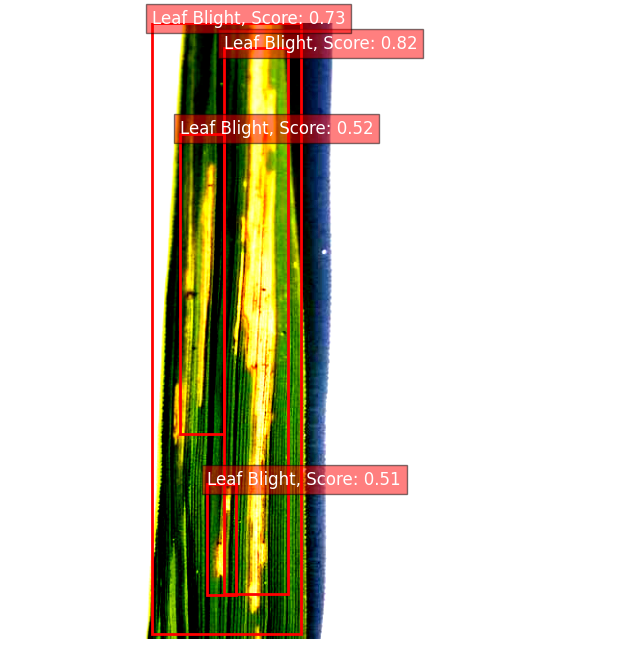

In [ ]:
import matplotlib.pyplot as plt

import torch
from PIL import Image
import torchvision.transforms as T

# Function to preprocess the image
def preprocess_image(image_path, device):
    # Define the transformation for the input image (Resize, Normalize, etc.)
    transform = T.Compose([
        T.Resize((640, 640)),  # Resize to 640x640
        T.ToTensor(),  # Convert image to tensor
        T.Normalize(mean=[0.485, 0.456, 0.406],  # Normalize using ImageNet mean
                    std=[0.229, 0.224, 0.225])  # Normalize using ImageNet std
    ])

    # Load the image using PIL
    image = Image.open(image_path).convert("RGB")

    # Apply transformations
    image_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension and move to device
    return image_tensor, image


# Function to visualize the prediction on a user-provided image
def visualize_user_image(image, predictions, class_names):
    # Convert tensor image to numpy array for visualization
    image_np = image.permute(1, 2, 0).cpu().numpy()  # Convert to HWC format

    # Draw predicted boxes
    boxes = predictions[0]['boxes'].cpu().detach().numpy()  # Use detach to avoid tracking gradients
    labels = predictions[0]['labels'].cpu().detach().numpy()
    scores = predictions[0]['scores'].cpu().detach().numpy()

    # Display the image
    plt.figure(figsize=(12, 8))
    plt.imshow(image_np)

    for box, label, score in zip(boxes, labels, scores):
        if score > 0.5:  # Show boxes with a score above a certain threshold
            x_min, y_min, x_max, y_max = box  # Adjust based on your box format
            rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                 fill=False, color='red', linewidth=2)
            plt.gca().add_patch(rect)
            # Replace label with class name
            class_name = class_names[int(label)]
            plt.text(x_min, y_min, f'{class_name}, Score: {score:.2f}',
                     color='white', fontsize=12, bbox=dict(facecolor='red', alpha=0.5))

    plt.axis('off')
    plt.show()

# Function to perform prediction on a user-provided image
def predict_on_user_image(model, image_path, device, class_names):
    # Preprocess the image
    image_tensor, original_image = preprocess_image(image_path, device)

    # Set the model to evaluation mode
    model.eval()

    # Run the model on the input image
    with torch.no_grad():
        # Remove the extra brackets to pass the 4D tensor directly
        predictions = model(image_tensor)

    # Visualize the results
    visualize_user_image(image_tensor[0], predictions, class_names)

# Example usage:
# Let's say the user provides an image file named 'test_image.jpg'
image_path = '/content/Rice-leaf-disease-1/train/bacterial_val-39-_JPG_jpg.rf.26c3c62405060c4fda0cccbcecd8916a.jpg'  # Replace with the actual image path
predict_on_user_image(model, image_path, device, class_names)


You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


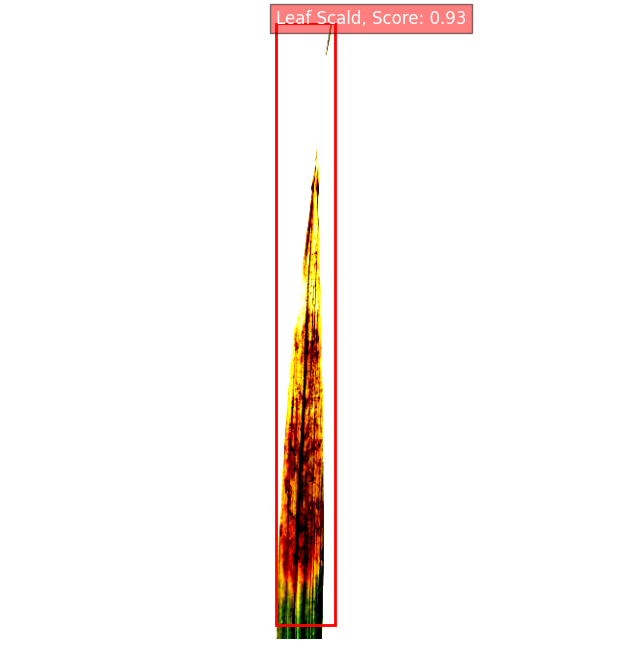

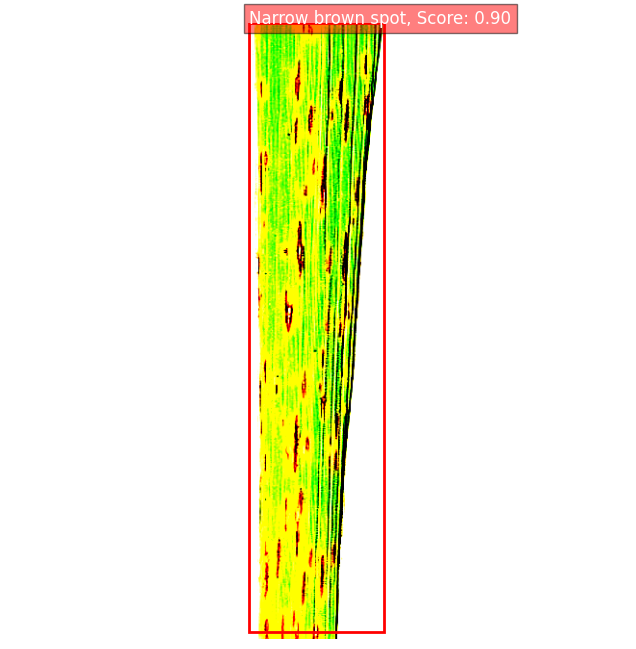

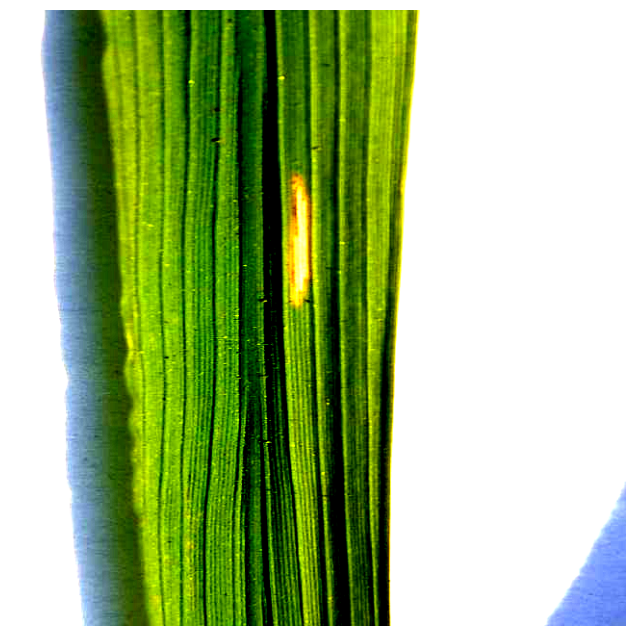

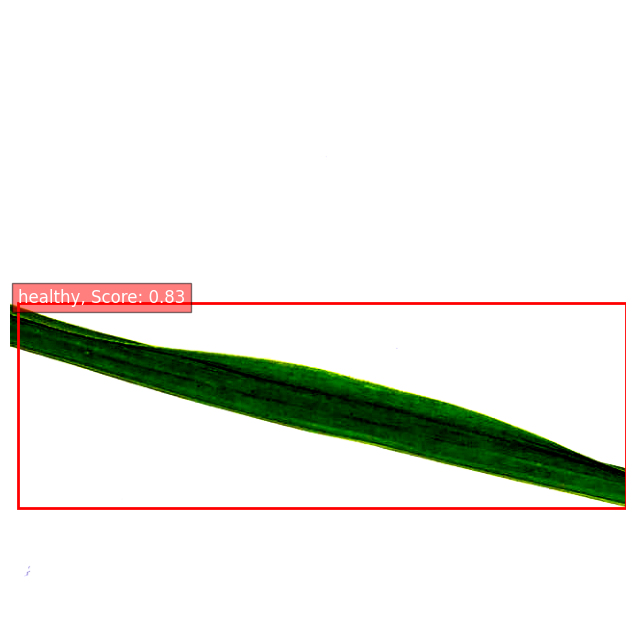

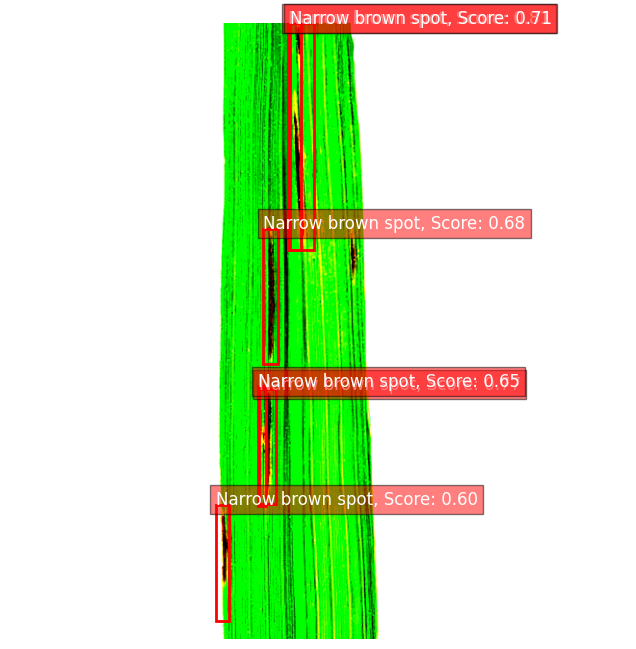

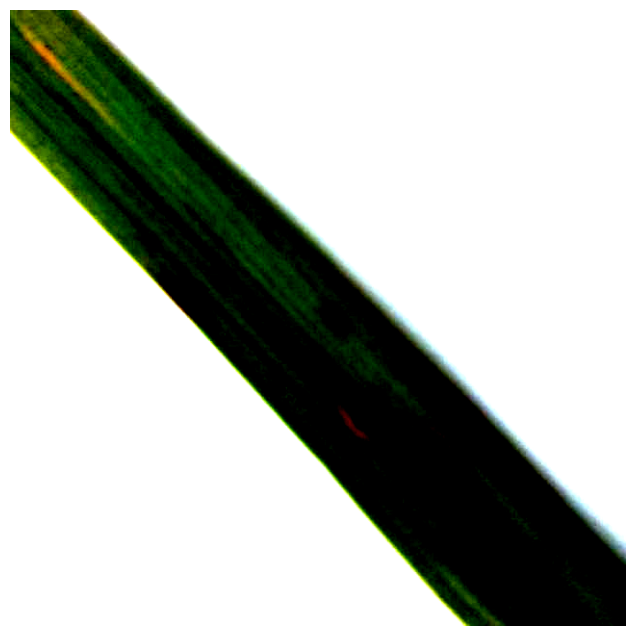

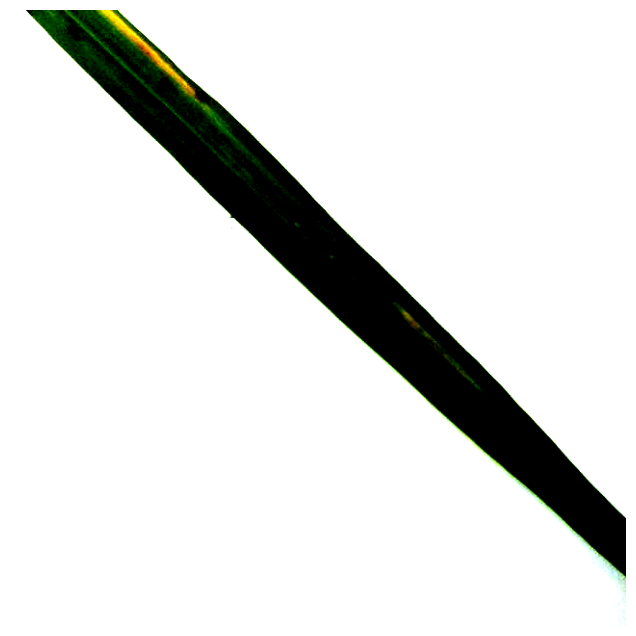

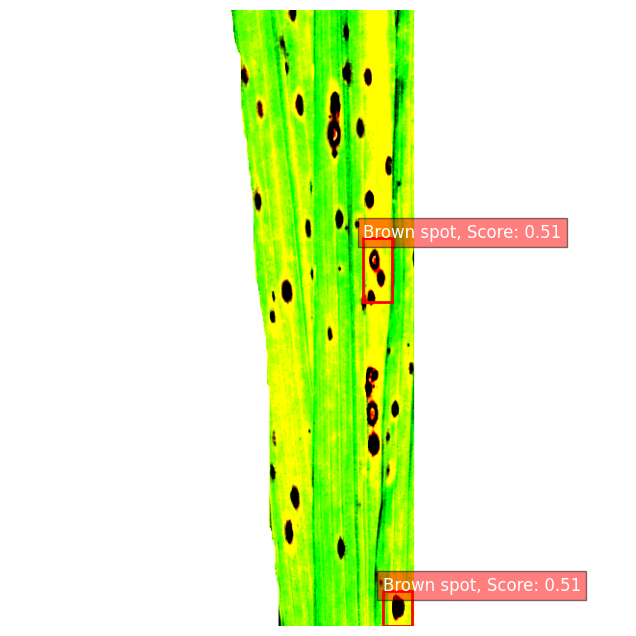

In [ ]:
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
class_names = {0: 'rice', 1: 'Brown spot', 2: 'Leaf Blight', 3: 'Leaf Scald', 4: 'Leaf blast', 5: 'Narrow brown spot', 6: 'healthy'}  # Update with your actual class names

# Function to visualize predictions
def visualize_predictions(images, predictions, class_names, num_samples=8):
    for i in range(num_samples):
        # Get the original image
        image = images[i].permute(1, 2, 0).cpu().numpy()  # Convert to HWC format

        # Draw predicted boxes
        boxes = predictions[i]['boxes'].cpu().detach().numpy()  # Use detach to avoid tracking gradients
        labels = predictions[i]['labels'].cpu().detach().numpy()
        scores = predictions[i]['scores'].cpu().detach().numpy()

        # Display the image
        plt.figure(figsize=(12, 8))
        plt.imshow(image)

        for box, label, score in zip(boxes, labels, scores):
            if score > 0.5:  # Show boxes with a score above a certain threshold
                x_min, y_min, x_max, y_max = box  # Adjust based on your box format
                rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                     fill=False, color='red', linewidth=2)
                plt.gca().add_patch(rect)
                # Replace label with class name
                class_name = class_names[int(label)]
                plt.text(x_min, y_min, f'{class_name}, Score: {score:.2f}',
                         color='white', fontsize=12, bbox=dict(facecolor='red', alpha=0.5))

        plt.axis('off')
        plt.show()

# Function to evaluate and get predictions from the model
def get_predictions(model, data_loader, device):
    model.eval()
    all_images = []
    all_predictions = []

    with torch.no_grad():
        for images, _ in data_loader:  # Get only images, ignore targets
            images = [transforms.ToTensor()(img).to(device) for img in images]
            predictions = model(images)  # Forward pass
            all_images.extend(images)
            all_predictions.extend(predictions)

    return all_images, all_predictions

# Load the Faster R-CNN model
model_path = '/content/faster_rcnn_resnet_custom.pt'
model = torch.load(model_path)
model.eval()

# Set device (CPU or CUDA)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Get predictions
all_images, all_predictions = get_predictions(model, test_loader, device)

# Visualize the results
visualize_predictions(all_images, all_predictions, class_names, num_samples=8)

## Eigen Cam

In [ ]:
!pip install torchcam
!pip install grad-cam
!pip install pycocotools
!pip install git+https://github.com/jacobgil/pytorch-grad-cam.git

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 73.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.4-py3-none-any.whl size=39589 sha256=302a0b609e86401013886ca362a23f2549a02d8be2d03b3b53e0b37fa794287f
  Stored in directory: /root/.cache/pip/wheels/50/b0/82/1f97b5348c7fe9f0ce0ba18497202cafa5dec4562bd5292680
Successfully built grad-cam
  Cloning https://github.com/jacobgil/pytorch-grad-cam.git to /tmp/pip-req-build-r3nq_ark
  Running command git clone --filter=blob:none --quiet https://github.com/jacobgil/pytorch-grad-cam.git /tmp/pip-req-build-r3nq_ark
  Resolved https://github.com/jacobgil/pytorch-grad-cam.git to commit ded280ccd2c4987d3c76a9ecd0994a8ec48fdc55
  Installing build dependencies ... done
  Getting requirements to build wheel ... don

<ipython-input-9-4b35a9c7006d>:82: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path, map_location=device)


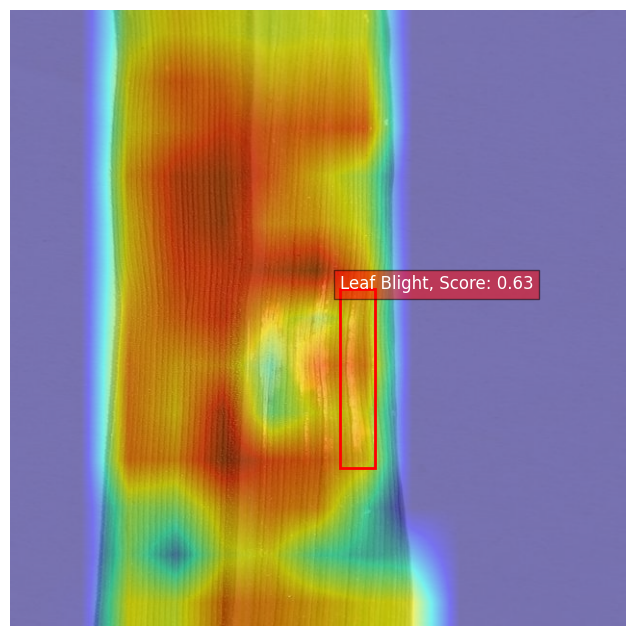

In [ ]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from PIL import Image
import torchvision.transforms as T
from pytorch_grad_cam import EigenCAM
from pytorch_grad_cam.utils.model_targets import FasterRCNNBoxScoreTarget
from pytorch_grad_cam.utils.reshape_transforms import fasterrcnn_reshape_transform
from pytorch_grad_cam.utils.image import show_cam_on_image

# Define the class names
class_name = {0: 'rice-leaf-diseases', 1: 'Brown spot', 2: 'Leaf Blight', 3: 'Leaf Scald', 4: 'Leaf blast', 5: 'Narrow brown spot', 6: 'healthy'}

# Function to preprocess the image
def preprocess_image(image_path, device):
    transform = T.Compose([
        T.Resize((640, 640)),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0).to(device)
    return image_tensor, image

# Function to visualize the image with predictions and CAM overlay
def visualize_user_image(image, predictions, class_names, cam_image=None):
    image_np = image.permute(1, 2, 0).cpu().numpy()
    boxes = predictions[0]['boxes'].cpu().detach().numpy()
    labels = predictions[0]['labels'].cpu().detach().numpy()
    scores = predictions[0]['scores'].cpu().detach().numpy()

    plt.figure(figsize=(12, 8))
    plt.imshow(image_np if cam_image is None else cam_image)

    for box, label, score in zip(boxes, labels, scores):
        if score > 0.5:
            x_min, y_min, x_max, y_max = box
            rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                 fill=False, color='red', linewidth=2)
            plt.gca().add_patch(rect)
            class_name = class_names[int(label)]
            plt.text(x_min, y_min, f'{class_name}, Score: {score:.2f}',
                     color='white', fontsize=12, bbox=dict(facecolor='red', alpha=0.5))

    plt.axis('off')
    plt.show()

# Function to perform prediction and apply EigenCAM
def predict_with_cam(model, image_path, device, class_names):
    image_tensor, original_image = preprocess_image(image_path, device)

    model.eval()
    with torch.no_grad():
        predictions = model(image_tensor)

    # Apply EigenCAM
    target_layers = [model.backbone]  # Backbone as target layer
    targets = [FasterRCNNBoxScoreTarget(labels=predictions[0]['labels'],
                                        bounding_boxes=predictions[0]['boxes'])]

    # Initialize EigenCAM without 'use_cuda' argument
    cam = EigenCAM(model=model, target_layers=target_layers, reshape_transform=fasterrcnn_reshape_transform)

    grayscale_cam = cam(input_tensor=image_tensor, targets=targets)
    grayscale_cam = grayscale_cam[0, :]  # Take the first image from batch

    # Convert image to float numpy array for overlay
    image_float_np = original_image.resize((640, 640))  # Resize for consistency
    image_float_np = np.array(image_float_np) / 255.0  # Normalize to [0, 1]

    # Overlay CAM on original image
    cam_image = show_cam_on_image(image_float_np, grayscale_cam, use_rgb=True)

    # Visualize the image with bounding boxes and CAM
    visualize_user_image(image_tensor[0], predictions, class_names, cam_image=cam_image)

# Load the Faster R-CNN model
model_path = '/content/faster_rcnn_resnet_custom.pt'

# Load model to CPU if CUDA is not available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = torch.load(model_path, map_location=device)
model.eval()


# Example usage:
image_path = '/content/bacterial_leaf_blight.jpg'  # Replace with the actual image path
predict_with_cam(model, image_path, device, class_name)


<ipython-input-15-2c43113e24ba>:113: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path, map_location=torch.device('cpu'))  # Load the model


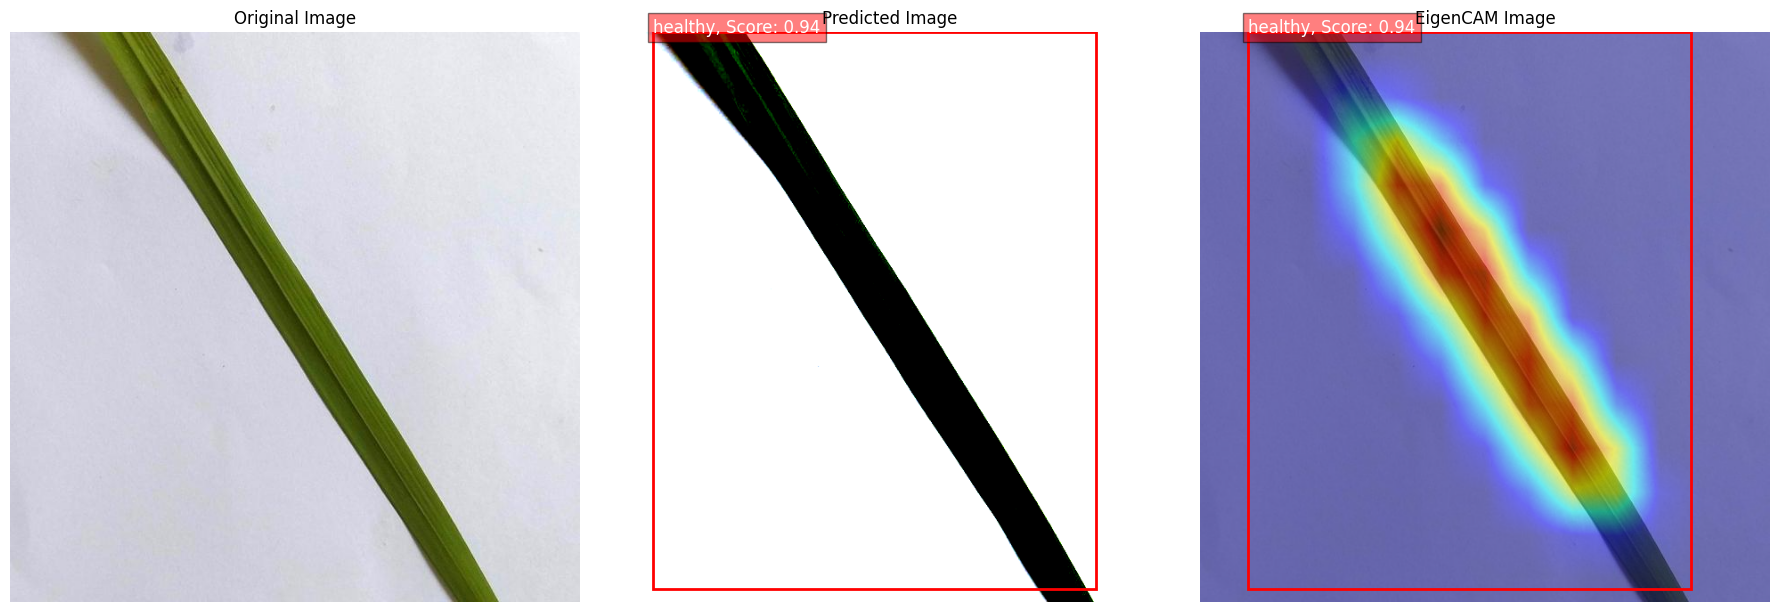

In [ ]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from PIL import Image
import torchvision.transforms as T
from pytorch_grad_cam import EigenCAM
from pytorch_grad_cam.utils.model_targets import FasterRCNNBoxScoreTarget
from pytorch_grad_cam.utils.reshape_transforms import fasterrcnn_reshape_transform
from pytorch_grad_cam.utils.image import show_cam_on_image

# Define the class names
class_name = {0: 'rice-leaf-diseases', 1: 'Brown spot', 2: 'Leaf Blight', 3: 'Leaf Scald', 4: 'Leaf blast', 5: 'Narrow brown spot', 6: 'healthy'}

# Unified function to preprocess the image
def preprocess_image(image_path, device):
    # Define the transformation for the input image (Resize, Normalize, etc.)
    transform = T.Compose([
        T.Resize((640, 640)),  # Resize to 640x640
        T.ToTensor(),  # Convert image to tensor
        T.Normalize(mean=[0.485, 0.456, 0.406],  # Normalize using ImageNet mean
                    std=[0.229, 0.224, 0.225])  # Normalize using ImageNet std
    ])

    # Load the image using PIL
    image = Image.open(image_path).convert("RGB")

    # Apply transformations
    image_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension and move to device
    return image_tensor, image

# Function to draw bounding boxes on an image
def draw_boxes(ax, boxes, labels, scores, class_names):
    for box, label, score in zip(boxes, labels, scores):
        if score > 0.5:  # Show boxes with a score above a certain threshold
            x_min, y_min, x_max, y_max = box  # Adjust based on your box format
            rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                 fill=False, color='red', linewidth=2)
            ax.add_patch(rect)  # Draw the bounding box
            class_name = class_names[int(label)]
            ax.text(x_min, y_min, f'{class_name}, Score: {score:.2f}',
                    color='white', fontsize=12, bbox=dict(facecolor='red', alpha=0.5))

# Function to visualize the original image, predicted image, and CAM overlay side by side
def visualize_side_by_side(original_image, image_tensor, predictions, class_names, cam_image):
    # Convert tensor image to numpy array for visualization
    image_np = image_tensor.permute(1, 2, 0).cpu().numpy()  # Convert to HWC format
    image_np = np.clip(image_np, 0, 1)  # Clip the values between 0 and 1 for valid imshow range

    # Create a figure to show all images side by side
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    # Draw predicted boxes
    boxes = predictions[0]['boxes'].cpu().detach().numpy()  # Use detach to avoid tracking gradients
    labels = predictions[0]['labels'].cpu().detach().numpy()
    scores = predictions[0]['scores'].cpu().detach().numpy()

    # Show the original image
    axs[0].imshow(np.array(original_image))
    axs[0].set_title("Original Image")
    axs[0].axis('off')

    # Show the predicted image
    axs[1].imshow(image_np)
    axs[1].set_title("Predicted Image")
    draw_boxes(axs[1], boxes, labels, scores, class_names)
    axs[1].axis('off')

    # Show the CAM overlay image
    axs[2].imshow(cam_image)
    axs[2].set_title("EigenCAM Image")
    draw_boxes(axs[2], boxes, labels, scores, class_names)  # Add boxes on the EigenCAM image
    axs[2].axis('off')

    # Display the images
    plt.tight_layout()
    plt.show()

# Function to perform prediction and apply EigenCAM
def predict_with_cam(model, image_path, device, class_names):
    # Preprocess the image using the unified function
    image_tensor, original_image = preprocess_image(image_path, device)

    # Set the model to evaluation mode
    model.eval()

    # Run the model on the input image
    with torch.no_grad():
        predictions = model(image_tensor)

    # Apply EigenCAM
    target_layers = [model.backbone]  # Backbone as target layer
    targets = [FasterRCNNBoxScoreTarget(labels=predictions[0]['labels'],
                                        bounding_boxes=predictions[0]['boxes'])]

    # Initialize EigenCAM
    cam = EigenCAM(model=model, target_layers=target_layers, reshape_transform=fasterrcnn_reshape_transform)

    grayscale_cam = cam(input_tensor=image_tensor, targets=targets)
    grayscale_cam = grayscale_cam[0, :]  # Take the first image from batch

    # Convert the original image to a float numpy array for overlay
    image_float_np = original_image.resize((640, 640))  # Resize for consistency
    image_float_np = np.array(image_float_np) / 255.0  # Normalize to [0, 1]

    # Overlay CAM on the original image
    cam_image = show_cam_on_image(image_float_np, grayscale_cam, use_rgb=True)

    # Visualize the original image, predicted image, and CAM side by side
    visualize_side_by_side(original_image, image_tensor[0], predictions, class_names, cam_image)

# Load the Faster R-CNN model
model = torch.load(model_path, map_location=torch.device('cpu'))  # Load the model

# Set device (CPU or CUDA)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Example usage:
image_path = '/content/healthy.jpg'  # Replace with the actual image path
predict_with_cam(model, image_path, device, class_name)


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


<ipython-input-16-3407e7bf61ea>:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path, map_location=torch.device('cpu'))  # Load the model


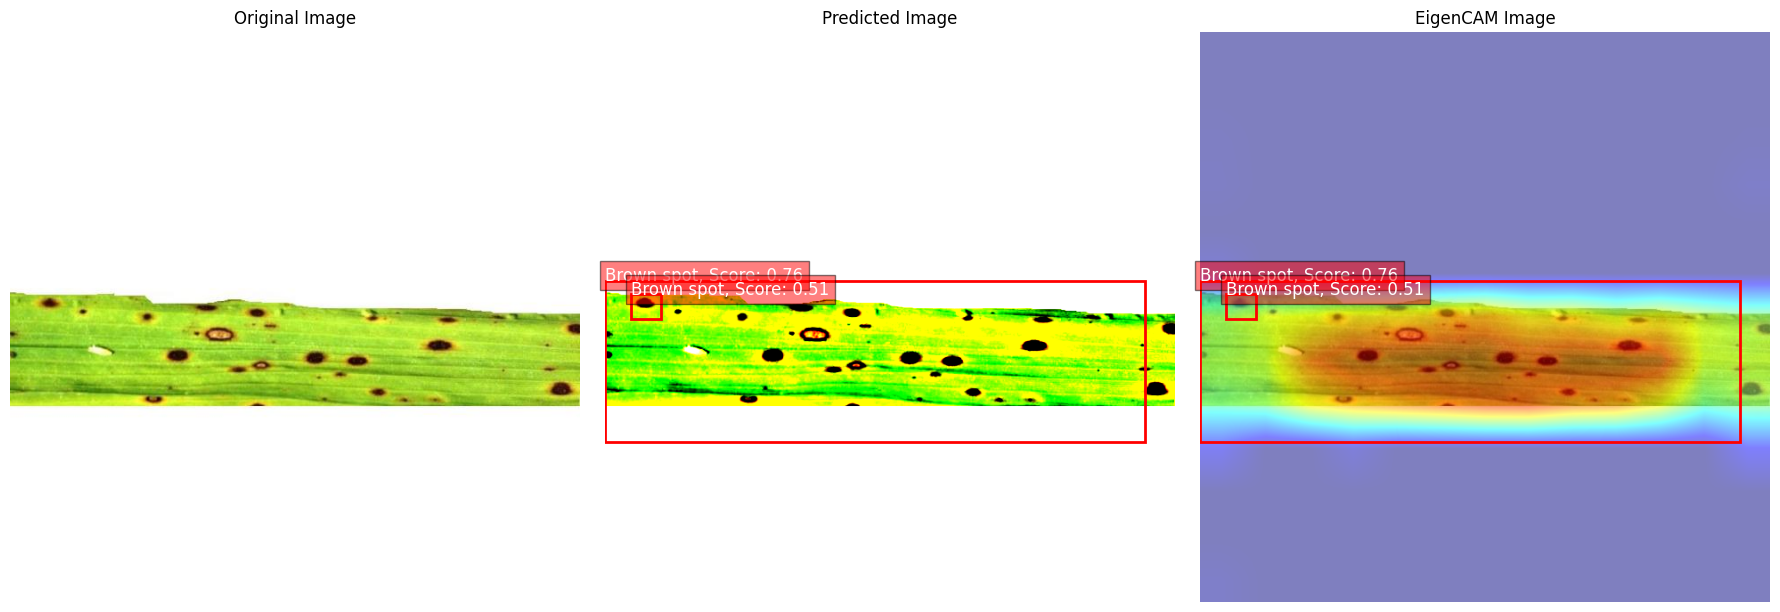

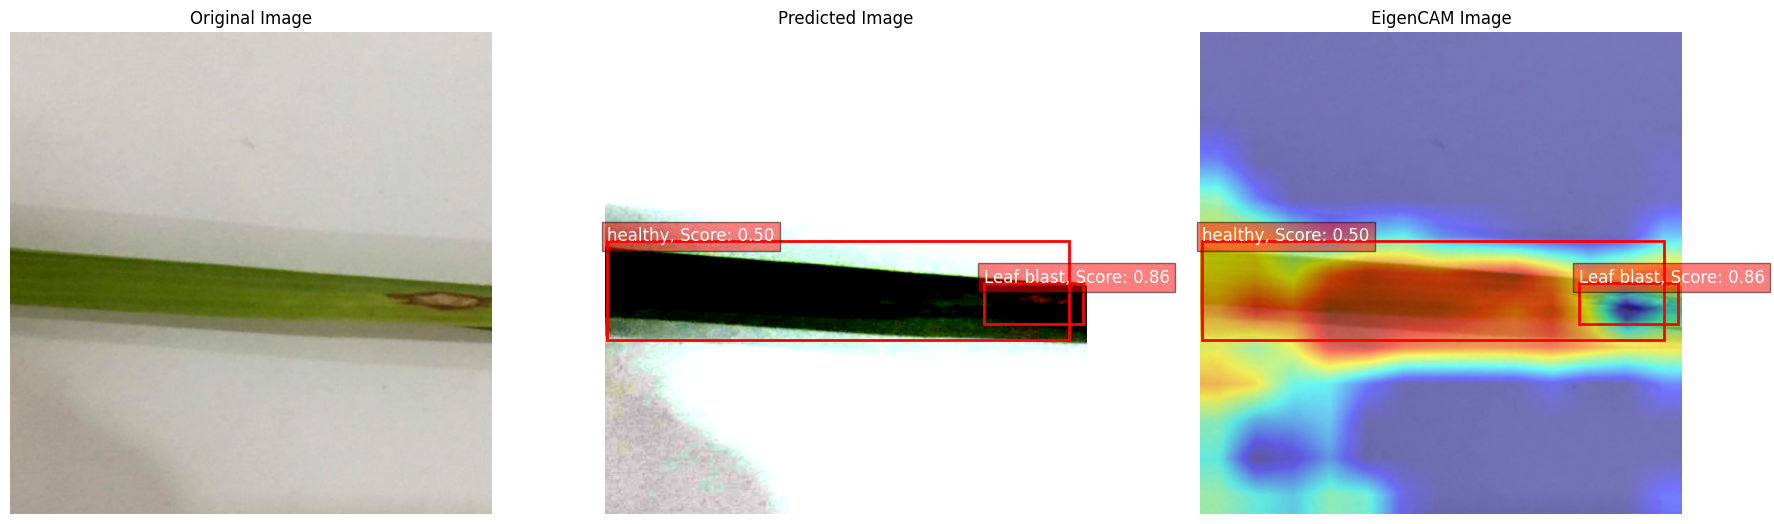

In [ ]:
import os
import random
import matplotlib.pyplot as plt
import torch
import numpy as np
from PIL import Image
import torchvision.transforms as T
# Import CocoDetection from torchvision.datasets
from torchvision.datasets import CocoDetection
from torch.utils.data import DataLoader
from pytorch_grad_cam import EigenCAM
from pytorch_grad_cam.utils.model_targets import FasterRCNNBoxScoreTarget
from pytorch_grad_cam.utils.reshape_transforms import fasterrcnn_reshape_transform
from pytorch_grad_cam.utils.image import show_cam_on_image


# Define the class names
class_name = {0: 'rice-leaf-diseases', 1: 'Brown spot', 2: 'Leaf Blight', 3: 'Leaf Scald', 4: 'Leaf blast', 5: 'Narrow brown spot', 6: 'healthy'}

# Unified function to preprocess the image
def preprocess_image(image, device):
    # Define the transformation for the input image (Resize to 640x640 to match CAM size)
    transform = T.Compose([
        T.Resize((640, 640)),  # Resize to 640x640 to ensure consistent dimensions
        T.ToTensor(),  # Convert image to tensor
        T.Normalize(mean=[0.485, 0.456, 0.406],  # Normalize using ImageNet mean
                    std=[0.229, 0.224, 0.225])  # Normalize using ImageNet std
    ])

    # Apply transformations
    image_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension and move to device
    return image_tensor, image.resize((640, 640))  # Resize the original image for overlay



# Function to draw bounding boxes on an image
def draw_boxes(ax, boxes, labels, scores, class_names):
    for box, label, score in zip(boxes, labels, scores):
        if score > 0.5:  # Show boxes with a score above a certain threshold
            x_min, y_min, x_max, y_max = box  # Adjust based on your box format
            rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                 fill=False, color='red', linewidth=2)
            ax.add_patch(rect)  # Draw the bounding box
            class_name = class_names[int(label)]
            ax.text(x_min, y_min, f'{class_name}, Score: {score:.2f}',
                    color='white', fontsize=12, bbox=dict(facecolor='red', alpha=0.5))

# Function to visualize the original image, predicted image, and CAM overlay side by side
def visualize_side_by_side(original_image, image_tensor, predictions, class_names, cam_image):
    # Convert tensor image to numpy array for visualization
    image_np = image_tensor.permute(1, 2, 0).cpu().numpy()  # Convert to HWC format
    image_np = np.clip(image_np, 0, 1)  # Clip the values between 0 and 1 for valid imshow range

    # Create a figure to show all images side by side
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    # Draw predicted boxes
    boxes = predictions[0]['boxes'].cpu().detach().numpy()  # Use detach to avoid tracking gradients
    labels = predictions[0]['labels'].cpu().detach().numpy()
    scores = predictions[0]['scores'].cpu().detach().numpy()

    # Show the original image
    axs[0].imshow(np.array(original_image))
    axs[0].set_title("Original Image")
    axs[0].axis('off')

    # Show the predicted image
    axs[1].imshow(image_np)
    axs[1].set_title("Predicted Image")
    draw_boxes(axs[1], boxes, labels, scores, class_names)
    axs[1].axis('off')

    # Show the CAM overlay image
    axs[2].imshow(cam_image)
    axs[2].set_title("EigenCAM Image")
    draw_boxes(axs[2], boxes, labels, scores, class_names)  # Add boxes on the EigenCAM image
    axs[2].axis('off')

    # Display the images
    plt.tight_layout()
    plt.show()

# Function to perform prediction and apply EigenCAM
def predict_with_cam(model, image, device, class_names):
    # Preprocess the image using the unified function
    image_tensor, original_image = preprocess_image(image, device)

    # Set the model to evaluation mode
    model.eval()

    # Run the model on the input image
    with torch.no_grad():
        predictions = model(image_tensor)

    # Apply EigenCAM
    target_layers = [model.backbone]  # Backbone as target layer
    targets = [FasterRCNNBoxScoreTarget(labels=predictions[0]['labels'],
                                        bounding_boxes=predictions[0]['boxes'])]

    # Initialize EigenCAM
    cam = EigenCAM(model=model, target_layers=target_layers, reshape_transform=fasterrcnn_reshape_transform)

    grayscale_cam = cam(input_tensor=image_tensor, targets=targets)
    grayscale_cam = grayscale_cam[0, :]  # Take the first image from batch

    # Convert the original image to a float numpy array for overlay
    image_float_np = original_image.resize((640, 640))  # Resize for consistency
    image_float_np = np.array(image_float_np) / 255.0  # Normalize to [0, 1]

    # Overlay CAM on the original image
    # Resize the CAM heatmap to match the original image size
    from skimage.transform import resize

    # After generating the grayscale CAM
    grayscale_cam_resized = resize(grayscale_cam, (image_float_np.shape[0], image_float_np.shape[1]), anti_aliasing=True)

    # Overlay CAM on the original image
    cam_image = show_cam_on_image(image_float_np, grayscale_cam_resized, use_rgb=True)


    # Visualize the original image, predicted image, and CAM side by side
    visualize_side_by_side(original_image, image_tensor[0], predictions, class_names, cam_image)

# Load test dataset using COCO format
test_dataset = CocoDetection(root=os.path.join(base_dir, 'test'),
                             annFile=os.path.join(base_dir, 'test', '_annotations.coco.json'),
                             transform=None)  # No transformation here, do it later

random_indices = random.sample(range(len(test_dataset)), 2)

# Load the Faster R-CNN model
model_path = '/content/faster_rcnn_full_model.pt'
model = torch.load(model_path, map_location=torch.device('cpu'))  # Load the model

# Set device (CPU or CUDA)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Loop over the 5 random images
for idx in random_indices:
    img, _ = test_dataset[idx]  # Get the image and its annotation
    predict_with_cam(model, img, device, class_name)
